# Analyse de données  <a class="tocSkip">

L'objectif de ce notebook est de mieux comprendre les données et analyses de l'article *Mutation dynamics and fitness effects followed in single cells*, par Lydia Robert, Jean Ollion, Jerome Robert, Xiaohu Song, Ivan Matic et Marina Elez (Science, 2018).

# Data exploration

In [2]:
library("gridExtra")
library("ggplot2")


## Mutation Accumulation experiment : data_microMA
### Files description

The folder contains 4 files giving the evolution of growth rate during one representative $\mu$MA experiment for 4 different strains, *mutH*, *mutT*, WT, MF1 (dataset_microMA_...) . Each column contains the values of one variable (time, generation or growth rate) for each time step for the mother cell of a single microchannel. The first two lines (i.e. first two values for each column) give respectively the index of the field of view and the index of the microchannel (~15channels for each field of view).


In [3]:
microMA_WT <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_WT.csv")
microMA_MutH <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MutH.csv")
microMA_MutT <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MutT.csv")
microMA_MF1 <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MF1.csv")

# Split the channel information (first 2 lines) from the growth rates
microMA_WT_channels <- microMA_WT[c(1,2),]
microMA_WT <- microMA_WT[-c(1,2),]
microMA_MutH_channels <- microMA_MutH[c(1,2),]
microMA_MutH <- microMA_MutH[-c(1,2),]
microMA_MutT_channels <- microMA_MutT[c(1,2),]
microMA_MutT <- microMA_MutT[-c(1,2),]
microMA_MF1_channels <- microMA_MF1[c(1,2),]
microMA_MF1 <- microMA_MF1[-c(1,2),]

In [4]:
microMA_MutH[1:6,1:9]

time generation growth.rate time.1 generation.1 growth.rate.1 time.2
3  0   1          0.03526965   0     1            0.03202591     0    
4  4   1          0.03526965   4     1            0.03202591     4    
5  8   2          0.03247045   8     1            0.03202591     8    
6 12   2          0.03247045  12     1            0.03202591    12    
7 16   2          0.03247045  16     2            0.03367152    16    
8 20   2          0.03247045  20     2            0.03367152    20    
  generation.2 growth.rate.2
3 1            0.02811950   
4 1            0.02811950   
5 2            0.02680181   
6 2            0.02680181   
7 2            0.02680181   
8 2            0.02680181

The folder also contains 4 files giving data on mortality of the mother cell for these experiments and one file with the mortality data for one representative experiment with the pMQ strain (induced with arabinose). For WT and mutH strains, the first 2 columns gives the index of the field of view and the index of the microchannel. The two last columns for WT and mutH and the two columns for mutT, MF1 and pMQ indicates the final state of the mother cell and the last frame. Several cases can occur :

  1. the mother cell can die during the experiment (final state=0, last frame=frame of the last division),
  2. it can stay alive and be imaged until the end of the experiment (final state=2, last frame=last frame of the movie),
  3. ?
  4. or imaging can stop before the end of the experiment for instance if the cells escape the channel (final state=4, last frame=last frame where the mother cell is imaged).


In [5]:
mortality_WT <- read.csv2("doi_10/All_data/data_microMA/mortality_WT.csv")
mortality_MutH <- read.csv2("doi_10/All_data/data_microMA/mortality_MutH.csv")
mortality_MutT <- read.csv2("doi_10/All_data/data_microMA/mortality_mutT.csv")
mortality_MF1 <- read.csv2("doi_10/All_data/data_microMA/mortality_MF1.csv")
mortality_pMQ <- read.csv2("doi_10/All_data/data_microMA/mortality_pMQara.csv")

# Name columns
names(mortality_WT) <- c("Field.view", "Microchannel", "Final.state", "Final.frame")
names(mortality_MutH) <- c("Field.view", "Microchannel", "Final.state", "Final.frame")

# Remove NA columns
mortality_MutT <- mortality_MutT[-which(sapply(mortality_MutT, function(x)all(is.na(x))))]
mortality_pMQ <- mortality_pMQ[-which(sapply(mortality_pMQ, function(x)all(is.na(x))))]

# Consider the final state as a factor
mortality_WT$Final.state <- as.factor(mortality_WT$Final.state)
mortality_MutH$Final.state <- as.factor(mortality_MutH$Final.state)
mortality_MutT$Final.state <- as.factor(mortality_MutT$Final.state)
mortality_MF1$Final.state <- as.factor(mortality_MF1$Final.state)
mortality_pMQ$Final.state <- as.factor(mortality_pMQ$Final.state)

# Remove lines with NAs
mortality_WT_NA <- mortality_WT[is.na(mortality_WT$Final.state),]
mortality_WT <- mortality_WT[!is.na(mortality_WT$Final.state),]
mortality_MutH_NA <- mortality_MutH[is.na(mortality_MutH$Final.state),]
mortality_MutH <- mortality_MutH[!is.na(mortality_MutH$Final.state),]
mortality_pMQ_NA <- mortality_pMQ[is.na(mortality_pMQ$Final.state),]
mortality_pMQ <- mortality_pMQ[!is.na(mortality_pMQ$Final.state),]

In [6]:
head(mortality_MutH)

Field.view Microchannel Final.state Final.frame
1 1          2            4            441       
2 1          3            4            346       
3 1          4            0            402       
4 1          5            2           1000       
5 1          6            0            359       
6 1          7            0            770

In [7]:
head(mortality_MutT)

Final.state Final.frame
1 0           695        
2 0           752        
3 0           932        
4 0           212        
5 0            16        
6 0           807

The folder contains also a file called "last_frames_for_microMA_analysis_MF1"which contains 4 columns which indicate : the index of the field of view, the index of the microchannel, the final frame for analysis and the final state ("alive" or "dead"). Here the final frame for analysis is the last frame where the cell is imaged if final state=alive but if the cell dies, it gives the frame where growth rate analysis should stop (~10 generations before death).


In [8]:
last_frames_for_microMA_analysis_MF1 <- read.csv2("doi_10/All_data/data_microMA/last_frames_for_microMA_analysis_MF1.csv")

head(last_frames_for_microMA_analysis_MF1)

Position Microchannel Final.frame.for.analysis final.state
1 xy40      3           667                      alive      
2 xy40     17           667                      alive      
3 xy40      6           614                      alive      
4 xy40      8           667                      alive      
5 xy40     12           184                      alive      
6 xy40      1           148                      alive

### Mortality
#### MutH




In [9]:
summary(mortality_MutH)

   Field.view      Microchannel Final.state  Final.frame    
 Min.   :  1.00   Min.   : 1    0:810       Min.   :   0.0  
 1st Qu.: 25.00   1st Qu.: 4    2:398       1st Qu.: 418.5  
 Median : 50.00   Median : 8    3:  1       Median : 700.0  
 Mean   : 50.19   Mean   : 8    4:271       Mean   : 659.0  
 3rd Qu.: 75.00   3rd Qu.:12                3rd Qu.:1000.0  
 Max.   :100.00   Max.   :15                Max.   :1000.0  

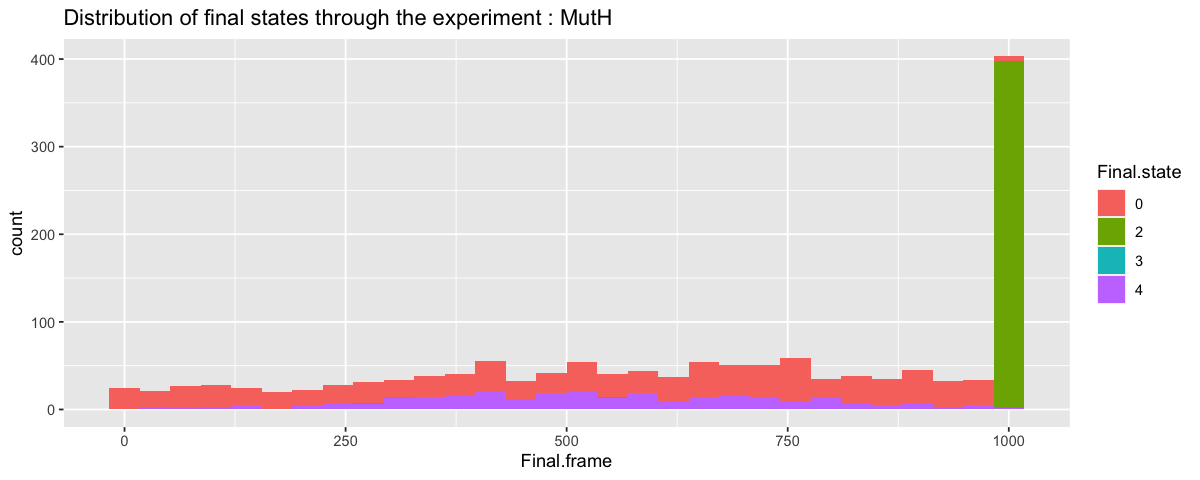

In [10]:
options(repr.plot.width = 10, repr.plot.height = 4)
ggplot(mortality_MutH, aes(x=Final.frame, fill=Final.state))+
  geom_histogram(bins = 30) +
  ggtitle("Distribution of final states through the experiment : MutH")

$\to$ Many bacteria survived until the end of the 1000 frames (state 2), the other died (state 0) or escaped (state 2) before then.


In [11]:
last_frame_MutH <- max(mortality_MutH$Final.frame)
survival_frame <- function(i, dataset){               # Proportion 
  return (mean(dataset$Final.frame>=i, na.rm = T))
}

mortality_MutH_noEscape <- mortality_MutH[mortality_MutH$Final.state != 4,]

survival_MutH <- data.frame(Time = 0:last_frame_MutH/60*4,  # One frame every 4 minutes
                            Survival = sapply(0:last_frame_MutH, survival_frame, dataset=mortality_MutH),
                            # Correct for escaped bacteria
                            Survival_noEscape = sapply(0:last_frame_MutH, survival_frame, dataset=mortality_MutH_noEscape))

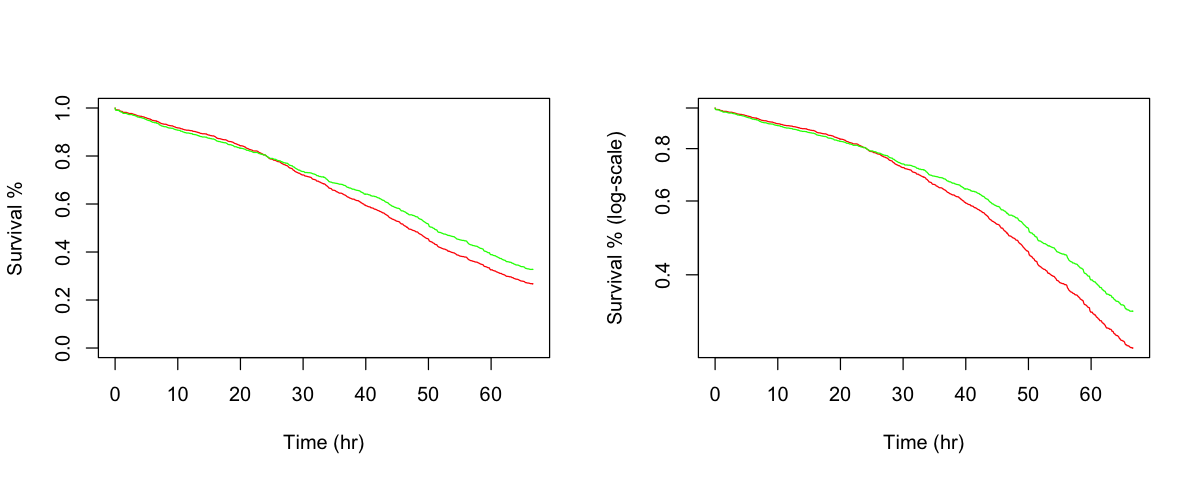

In [12]:
par(mfrow=c(1,2))
options(repr.plot.width = 10, repr.plot.height = 4)

plot(x=survival_MutH$Time,
     y=survival_MutH$Survival,
     type="l",
     col="red", 
     xlab = "Time (hr)", 
     ylab="Survival %", 
     ylim = c(0.0001,1))
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col="green")

plot(x=survival_MutH$Time,
     y=survival_MutH$Survival,
     type="l",
     col="red",
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)", 
     # ylim = c(0.1,1), 
     log="y")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col="green")

#### All lines


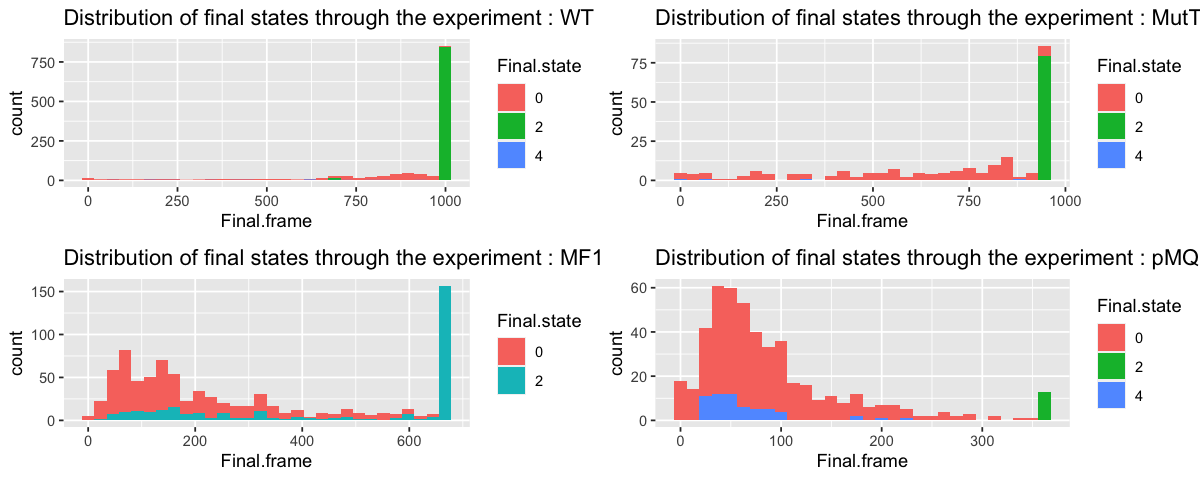

In [13]:
p_WT <- ggplot(mortality_WT, aes(x=Final.frame, fill=Final.state)) +
               geom_histogram(bins = 30) +
               ggtitle("Distribution of final states through the experiment : WT")

p_MutT <- ggplot(mortality_MutT, aes(x=Final.frame, fill=Final.state)) +
                 geom_histogram(bins = 30) +
                 ggtitle("Distribution of final states through the experiment : MutT")

p_MF1 <- ggplot(mortality_MF1, aes(x=Final.frame, fill=Final.state)) +
                geom_histogram(bins = 30) +
                ggtitle("Distribution of final states through the experiment : MF1")

p_pMQ <- ggplot(mortality_pMQ, aes(x=Final.frame, fill=Final.state)) +
                geom_histogram(bins = 30) +
                ggtitle("Distribution of final states through the experiment : pMQ")

grid.arrange(p_WT, p_MutT, p_MF1, p_pMQ, ncol = 2, nrow = 2)

In [14]:
last_frame_WT <- max(mortality_WT$Final.frame)
last_frame_MutT <- max(mortality_MutT$Final.frame)
last_frame_MF1 <- max(mortality_MF1$Final.frame)
last_frame_pMQ <- max(mortality_pMQ$Final.frame)

mortality_WT_noEscape <- mortality_WT[mortality_WT$Final.state != 4,]
mortality_MutT_noEscape <- mortality_MutT[mortality_MutT$Final.state != 4,]
mortality_MF1_noEscape <- mortality_MF1[mortality_MF1$Final.state != 4,]
mortality_pMQ_noEscape <- mortality_pMQ[mortality_pMQ$Final.state != 4,]

survival_WT <- data.frame(Time = 0:last_frame_WT/60*4,  # One frame every 4 minutes
                          Survival = sapply(0:last_frame_WT, survival_frame, dataset=mortality_WT),
                          Survival_noEscape = sapply(0:last_frame_WT, survival_frame, dataset=mortality_WT_noEscape))
survival_MutT <- data.frame(Time = 0:last_frame_MutT/60*4, 
                            Survival = sapply(0:last_frame_MutT, survival_frame, dataset=mortality_MutT),
                            Survival_noEscape = sapply(0:last_frame_MutT, survival_frame, dataset=mortality_MutT_noEscape))
survival_MF1 <- data.frame(Time = 0:last_frame_MF1/60*4, 
                           Survival = sapply(0:last_frame_MF1, survival_frame, dataset=mortality_MF1),
                           Survival_noEscape = sapply(0:last_frame_MF1, survival_frame, dataset=mortality_MF1_noEscape))
survival_pMQ <- data.frame(Time = 0:last_frame_pMQ/60*4, 
                           Survival = sapply(0:last_frame_pMQ, survival_frame, dataset=mortality_pMQ),
                           Survival_noEscape = sapply(0:last_frame_pMQ, survival_frame, dataset=mortality_pMQ_noEscape))

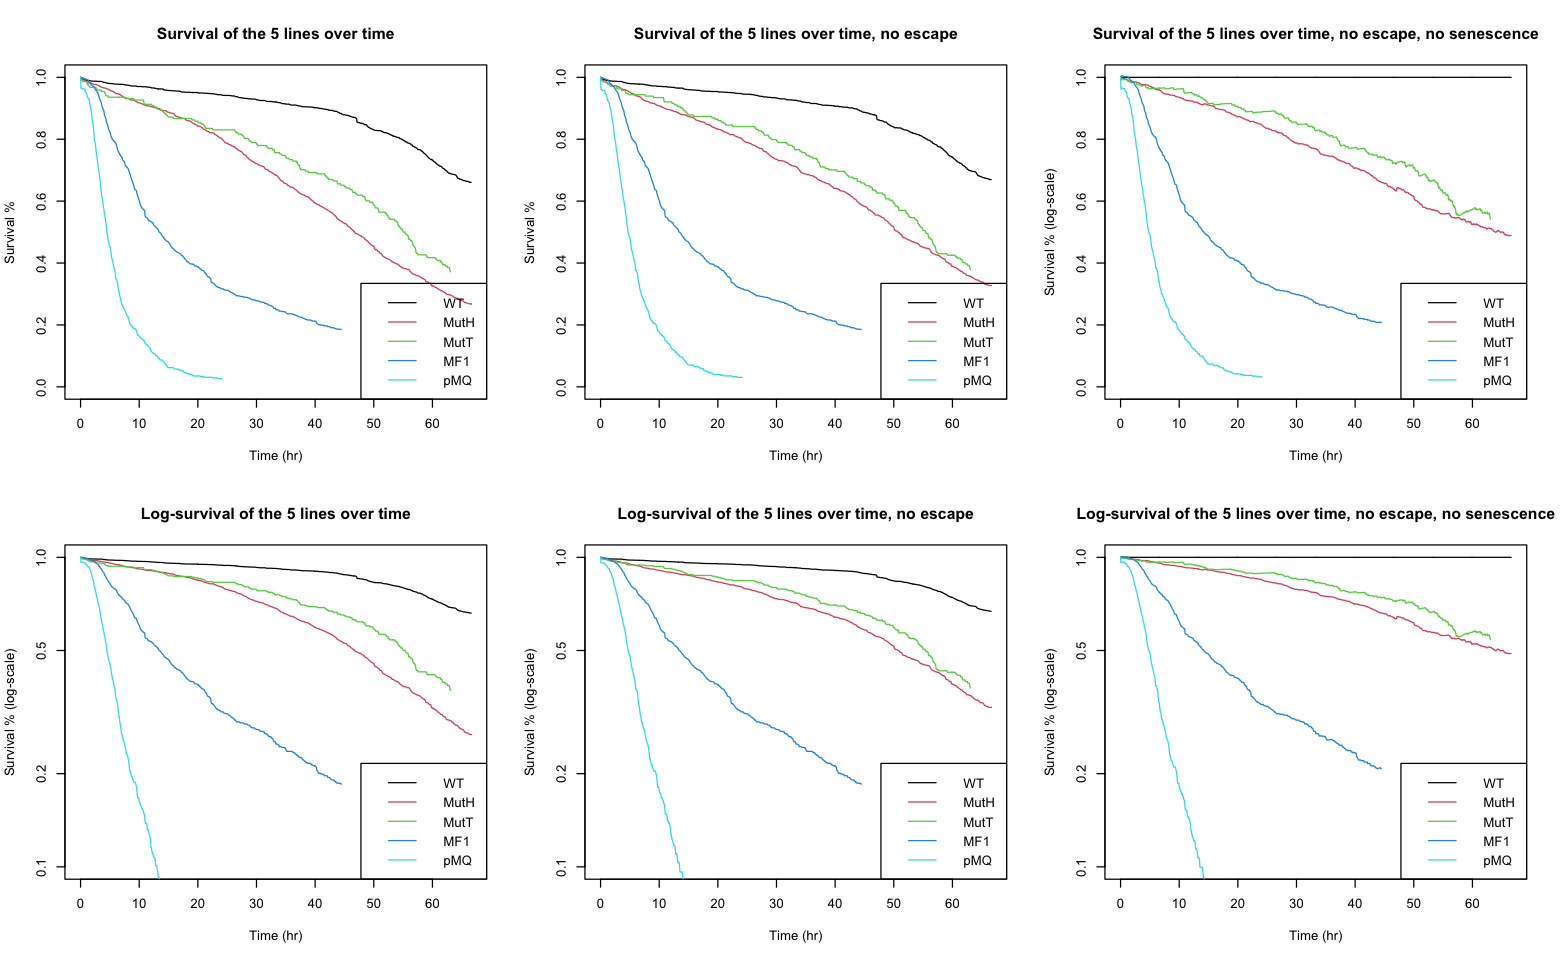

In [15]:
par(mfrow=c(2,3))
options(repr.plot.width = 13, repr.plot.height = 8)


plot(x=survival_WT$Time,
     y=survival_WT$Survival,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival %", 
     ylim = c(0,1),
     main = "Survival of the 5 lines over time")
lines(x=survival_MutH$Time, y=survival_MutH$Survival, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=5)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival %", 
     ylim = c(0,1),
     main = "Survival of the 5 lines over time, no escape")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=5)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape/survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)",
     ylim = c(0,1),
     main = "Survival of the 5 lines over time, no escape, no senescence")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutH$Survival_noEscape)], col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutT$Survival_noEscape)], col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MF1$Survival_noEscape)], col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_pMQ$Survival_noEscape)], col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=5)

plot(x=survival_WT$Time,
     y=survival_WT$Survival,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)",
     ylim = c(0.1,1),
     log = "y", 
     main = "Log-survival of the 5 lines over time")
lines(x=survival_MutH$Time, y=survival_MutH$Survival, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=5)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)", 
     ylim = c(0.1,1),
     log="y",
     main = "Log-survival of the 5 lines over time, no escape")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=5)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape/survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Time (hr)", 
     ylab="Survival % (log-scale)", 
     ylim = c(0.1,1),
     log="y",
     main = "Log-survival of the 5 lines over time, no escape, no senescence")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutH$Survival_noEscape)], col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutT$Survival_noEscape)], col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MF1$Survival_noEscape)], col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_pMQ$Survival_noEscape)], col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=5)


### Growth rates
#### MutH


In [16]:
head(microMA_MutH[,1:9])

time generation growth.rate time.1 generation.1 growth.rate.1 time.2
3  0   1          0.03526965   0     1            0.03202591     0    
4  4   1          0.03526965   4     1            0.03202591     4    
5  8   2          0.03247045   8     1            0.03202591     8    
6 12   2          0.03247045  12     1            0.03202591    12    
7 16   2          0.03247045  16     2            0.03367152    16    
8 20   2          0.03247045  20     2            0.03367152    20    
  generation.2 growth.rate.2
3 1            0.02811950   
4 1            0.02811950   
5 2            0.02680181   
6 2            0.02680181   
7 2            0.02680181   
8 2            0.02680181

In [17]:
summary(microMA_MutH[,1:9])

      time        generation      growth.rate          time.1    
 Min.   :   0   Min.   :  1.00   Min.   :0.01835   Min.   :   0  
 1st Qu.: 999   1st Qu.: 45.00   1st Qu.:0.02770   1st Qu.: 999  
 Median :1998   Median : 90.00   Median :0.02883   Median :1998  
 Mean   :1998   Mean   : 90.82   Mean   :0.02974   Mean   :1998  
 3rd Qu.:2997   3rd Qu.:136.00   3rd Qu.:0.03127   3rd Qu.:2997  
 Max.   :3996   Max.   :183.00   Max.   :0.07248   Max.   :3996  
  generation.1   growth.rate.1         time.2      generation.2   
 Min.   :  1.0   Min.   :0.01148   Min.   :   0   Min.   :  1.00  
 1st Qu.: 36.0   1st Qu.:0.01650   1st Qu.: 999   1st Qu.: 48.75  
 Median : 63.0   Median :0.01753   Median :1998   Median : 97.00  
 Mean   : 63.8   Mean   :0.01859   Mean   :1998   Mean   : 91.61  
 3rd Qu.: 92.0   3rd Qu.:0.01944   3rd Qu.:2997   3rd Qu.:140.00  
 Max.   :122.0   Max.   :0.03386   Max.   :3996   Max.   :165.00  
 growth.rate.2       
 Min.   :-0.0009553  
 1st Qu.: 0.0252990  
 Me

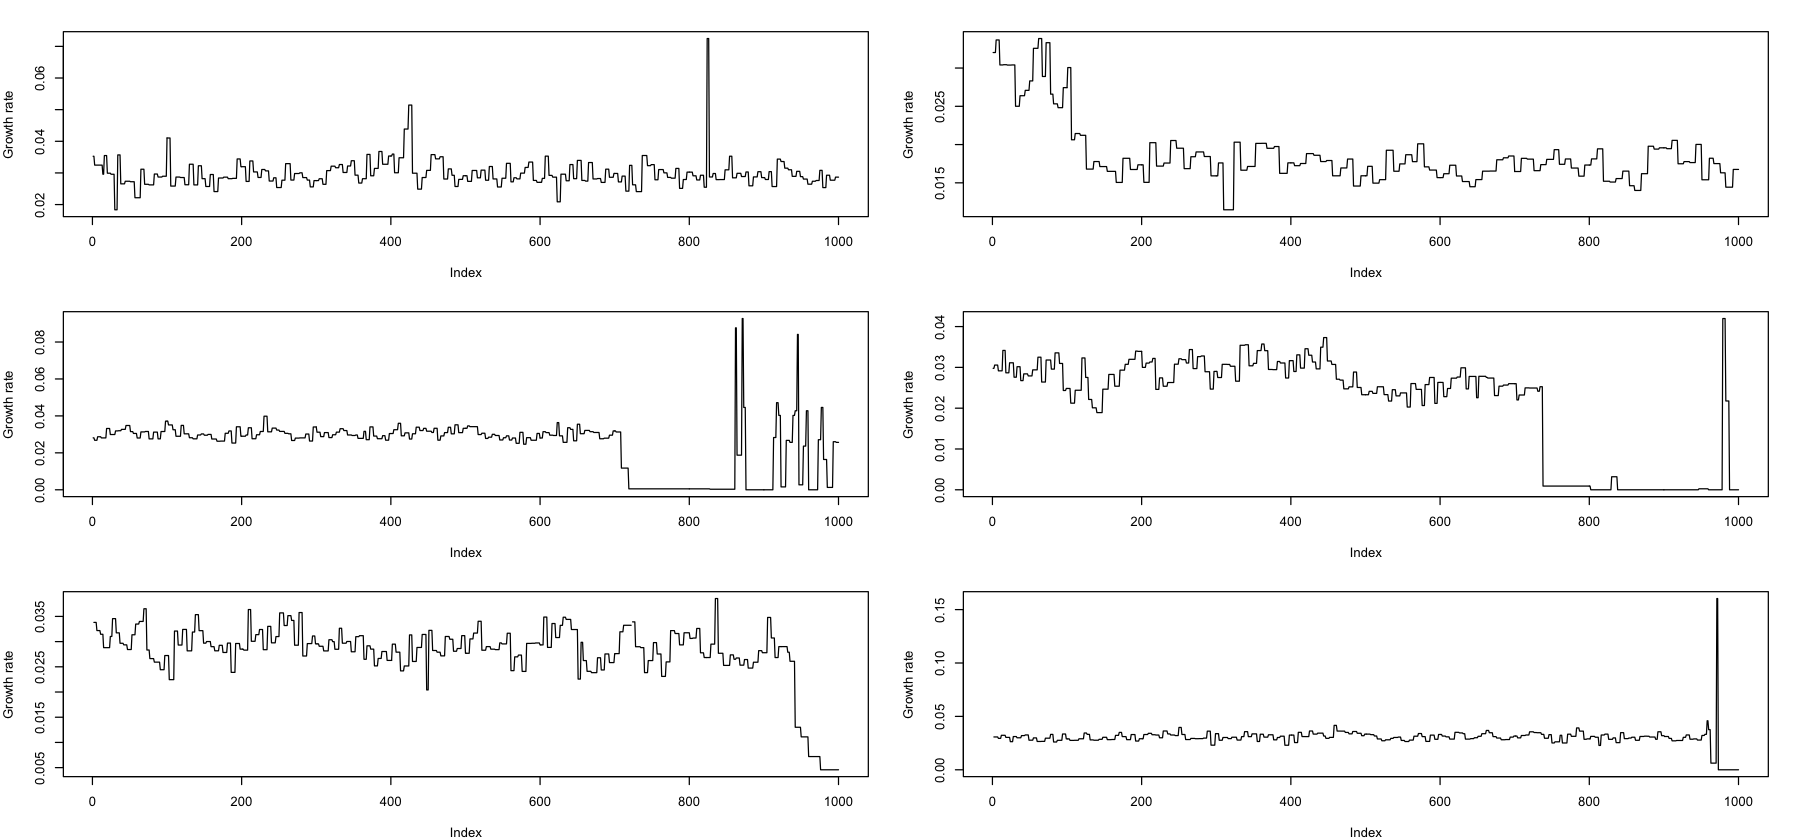

In [18]:
microMA_MutH_growthRates <- microMA_MutH[seq(3, dim(microMA_MutH)[2], 3)]
microMA_MutH_growthRates[microMA_MutH_growthRates<0] <- 0  # Set negative growth rates to 0

par(mfrow=c(3,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 7)

for (i in 1:6){
    plot(microMA_MutH_growthRates[,i], type="l", ylab = "Growth rate")
}

In [19]:
moment_expectation <- function(k, dataset){
  return (rowMeans(dataset**k, na.rm = T))
}

k_values <- 1:10
moments_expectations_MutH <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_MutH_growthRates))
names(moments_expectations_MutH) <- paste("k.", k_values, sep = "")

head(moments_expectations_MutH)

k.1        k.2          k.3          k.4          k.5          k.6         
3 0.03250712 0.0017362311 2.698378e-04 8.237702e-05 3.071159e-05 1.239086e-05
4 0.03209952 0.0015663271 2.167729e-04 6.427495e-05 2.388514e-05 9.633859e-06
5 0.03108476 0.0010832813 4.952009e-05 3.714617e-06 4.312110e-07 6.107275e-08
6 0.03051039 0.0010039712 3.821597e-05 1.992637e-06 1.593285e-07 1.733276e-08
7 0.03016438 0.0009655447 3.399317e-05 1.495474e-06 9.803644e-08 9.590835e-09
8 0.02974964 0.0009280131 3.095281e-05 1.242705e-06 7.609726e-08 7.610804e-09
  k.7          k.8          k.9          k.10        
3 5.228312e-06 2.269559e-06 1.003748e-06 4.495617e-07
4 4.064897e-06 1.764528e-06 7.803905e-07 3.495236e-07
5 9.286288e-09 1.455587e-09 2.323287e-10 3.758676e-11
6 2.165219e-09 2.856654e-10 3.864048e-11 5.302090e-12
7 1.173708e-09 1.574574e-10 2.193224e-11 3.109624e-12
8 9.889847e-10 1.397301e-10 2.018966e-11 2.934855e-12

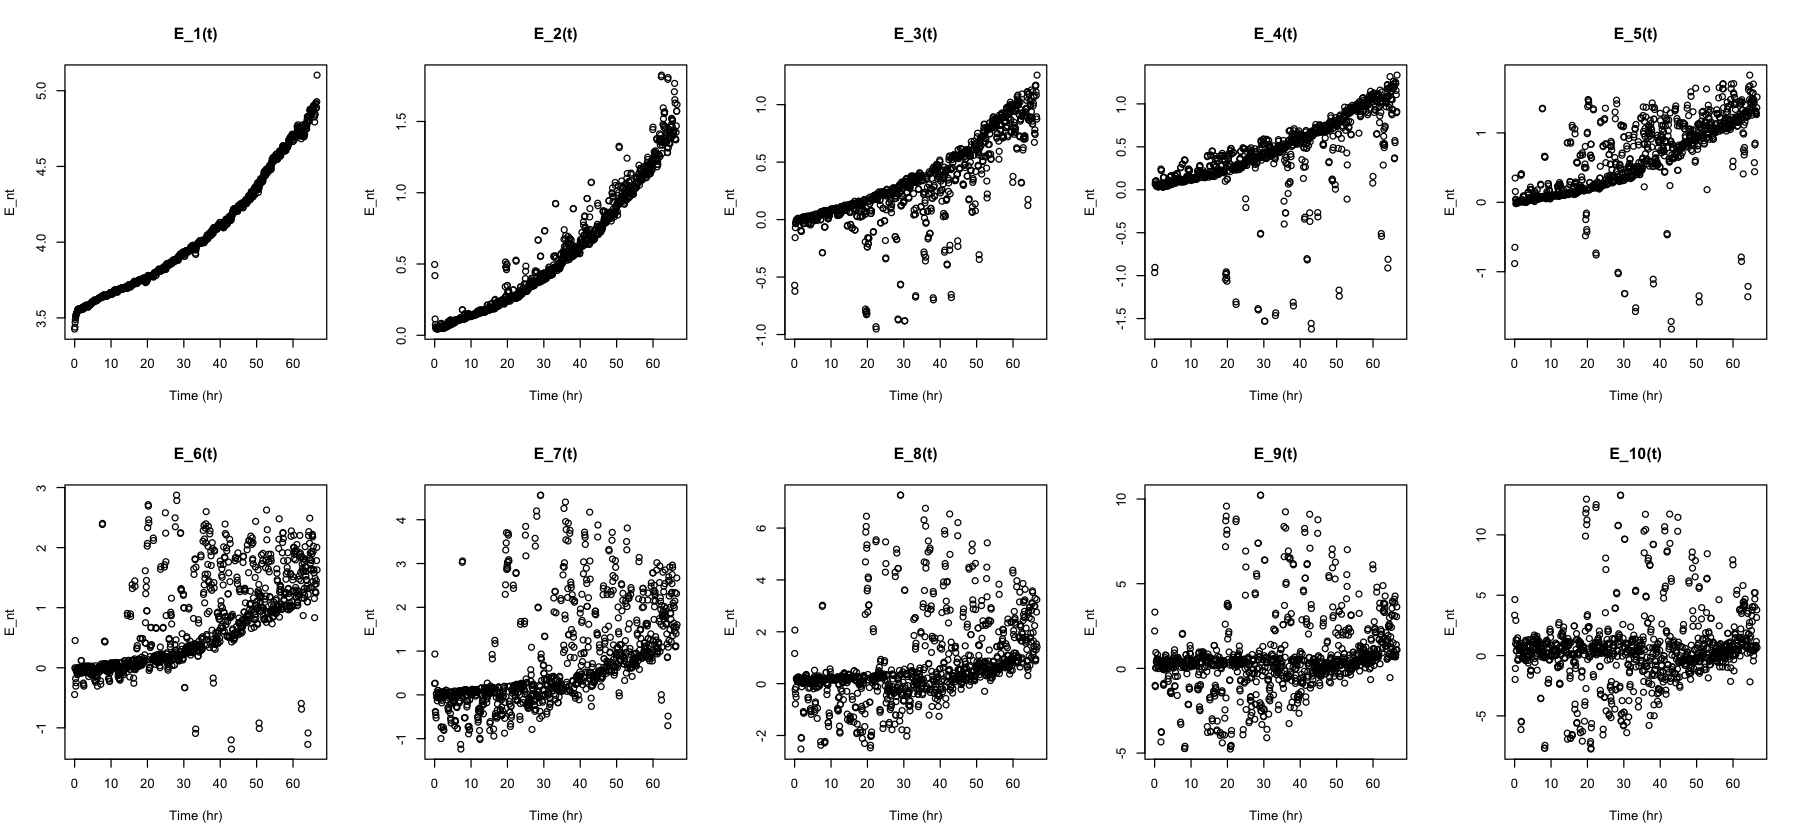

In [20]:
log_choose <- function(k, n, moments_expectations){
  return ((-1)**k*choose(n,k)*log(moments_expectations[,k]))
}

par(mfrow = c(2,5))

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_MutH))
  plot(x = microMA_MutH$time/60, 
       y = E_nt, 
       xlab = "Time (hr)",
       main = paste("E_", n, "(t)", sep = ""))
}

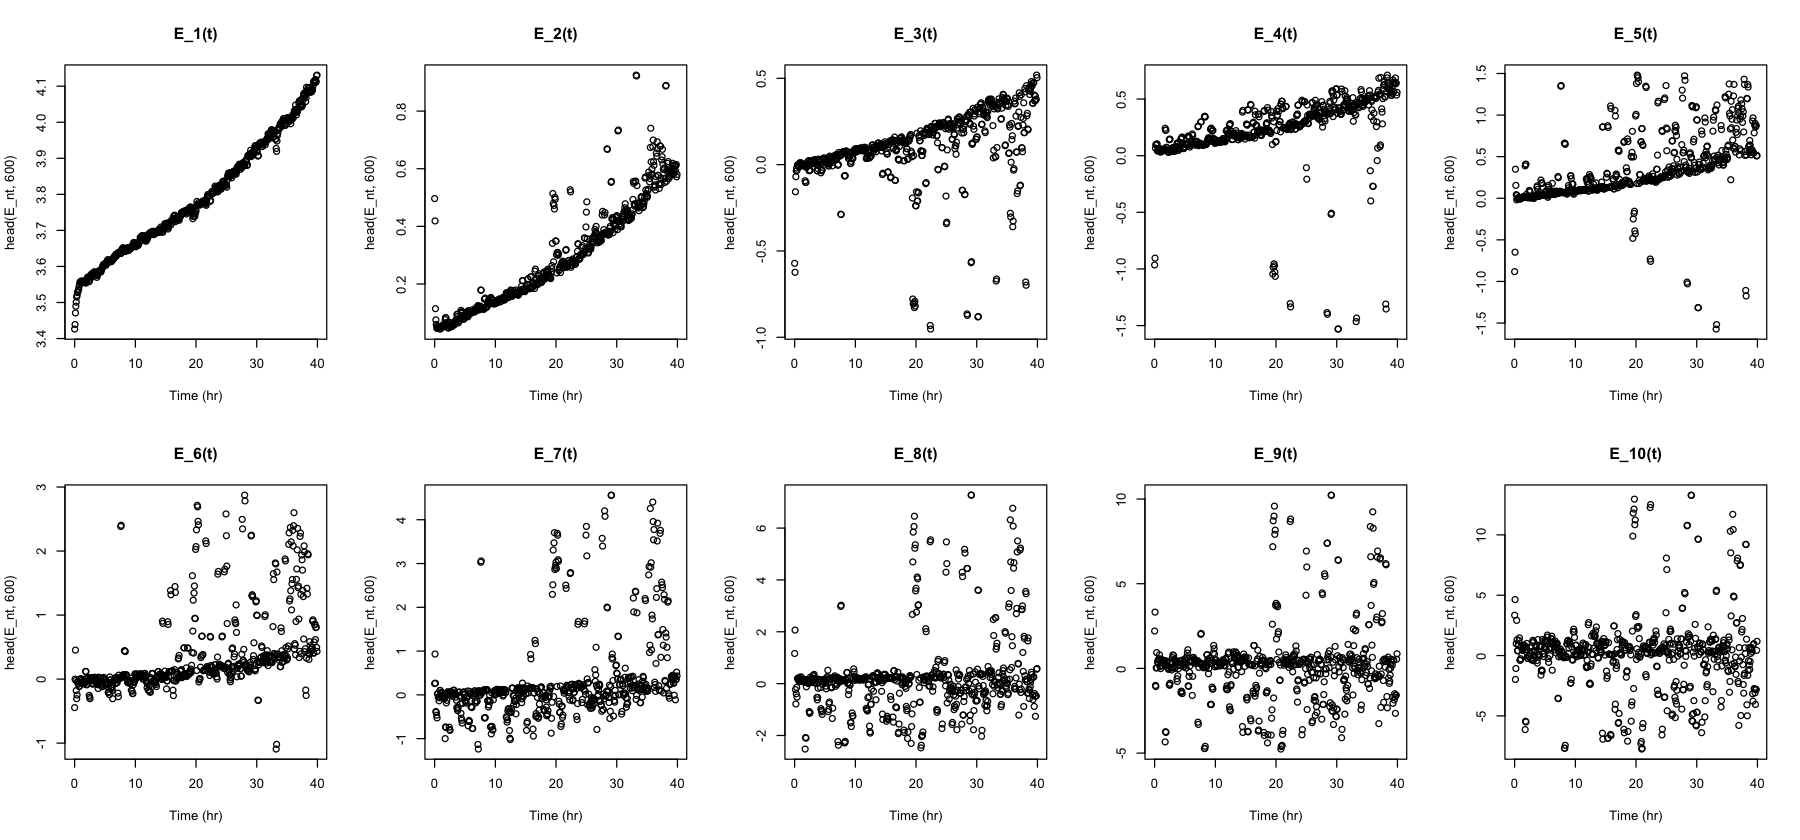

In [21]:
par(mfrow = c(2,5))

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_MutH))
  plot(x = head(microMA_MutH$time/60, 600), 
       y = head(E_nt, 600), 
       xlab = "Time (hr)",
       main = paste("E_", n, "(t)", sep = ""))
}

#### WT

In [22]:
head(microMA_WT[,1:9])

time generation growth.rate time.1 generation.1 growth.rate.1 time.2
3  0   1          0.01553294   0     1                    NA     0    
4  4   1          0.01553294   4     2            0.03227775     4    
5  8   2          0.03122056   8     2            0.03227775     8    
6 12   2          0.03122056  12     2            0.03227775    12    
7 16   2          0.03122056  16     2            0.03227775    16    
8 20   2          0.03122056  20     2            0.03227775    20    
  generation.2 growth.rate.2
3 1                    NA   
4 2            0.03030216   
5 2            0.03030216   
6 2            0.03030216   
7 2            0.03030216   
8 2            0.03030216

In [75]:
microMA_WT_growthRates <- microMA_WT[seq(3, dim(microMA_WT)[2], 3)]
microMA_WT_growthRates[microMA_WT_growthRates < 0] <- 0  # Set negative growth rates to 0

k_values <- 1:10
moments_expectations_WT <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_WT_growthRates))
names(moments_expectations_WT) <- paste("k.", k_values, sep = "")

head(moments_expectations_WT)

k.1        k.2         k.3          k.4          k.5          k.6         
3 0.04219302 0.003542421 5.795390e-04 1.352807e-04 3.742967e-05 1.151046e-05
4 0.03983673 0.003093899 4.798407e-04 1.098080e-04 3.017507e-05 9.256392e-06
5 0.03578041 0.001957415 1.756805e-04 2.322704e-05 3.825659e-06 7.188368e-07
6 0.03198789 0.001330981 7.906234e-05 7.102732e-06 8.616417e-07 1.236043e-07
7 0.03016124 0.001077701 4.612796e-05 2.544906e-06 1.823724e-07 1.579636e-08
8 0.02937371 0.001001953 3.994537e-05 2.023432e-06 1.351320e-07 1.121521e-08
  k.7          k.8          k.9          k.10        
3 3.827929e-06 1.352757e-06 5.009010e-07 1.920607e-07
4 3.075508e-06 1.086509e-06 4.022710e-07 1.542376e-07
5 1.479571e-07 3.252985e-08 7.497951e-09 1.786866e-09
6 1.948140e-08 3.254160e-09 5.646228e-10 1.004824e-10
7 1.525249e-09 1.561459e-10 1.653093e-11 1.788138e-12
8 1.056148e-09 1.061002e-10 1.102687e-11 1.168994e-12

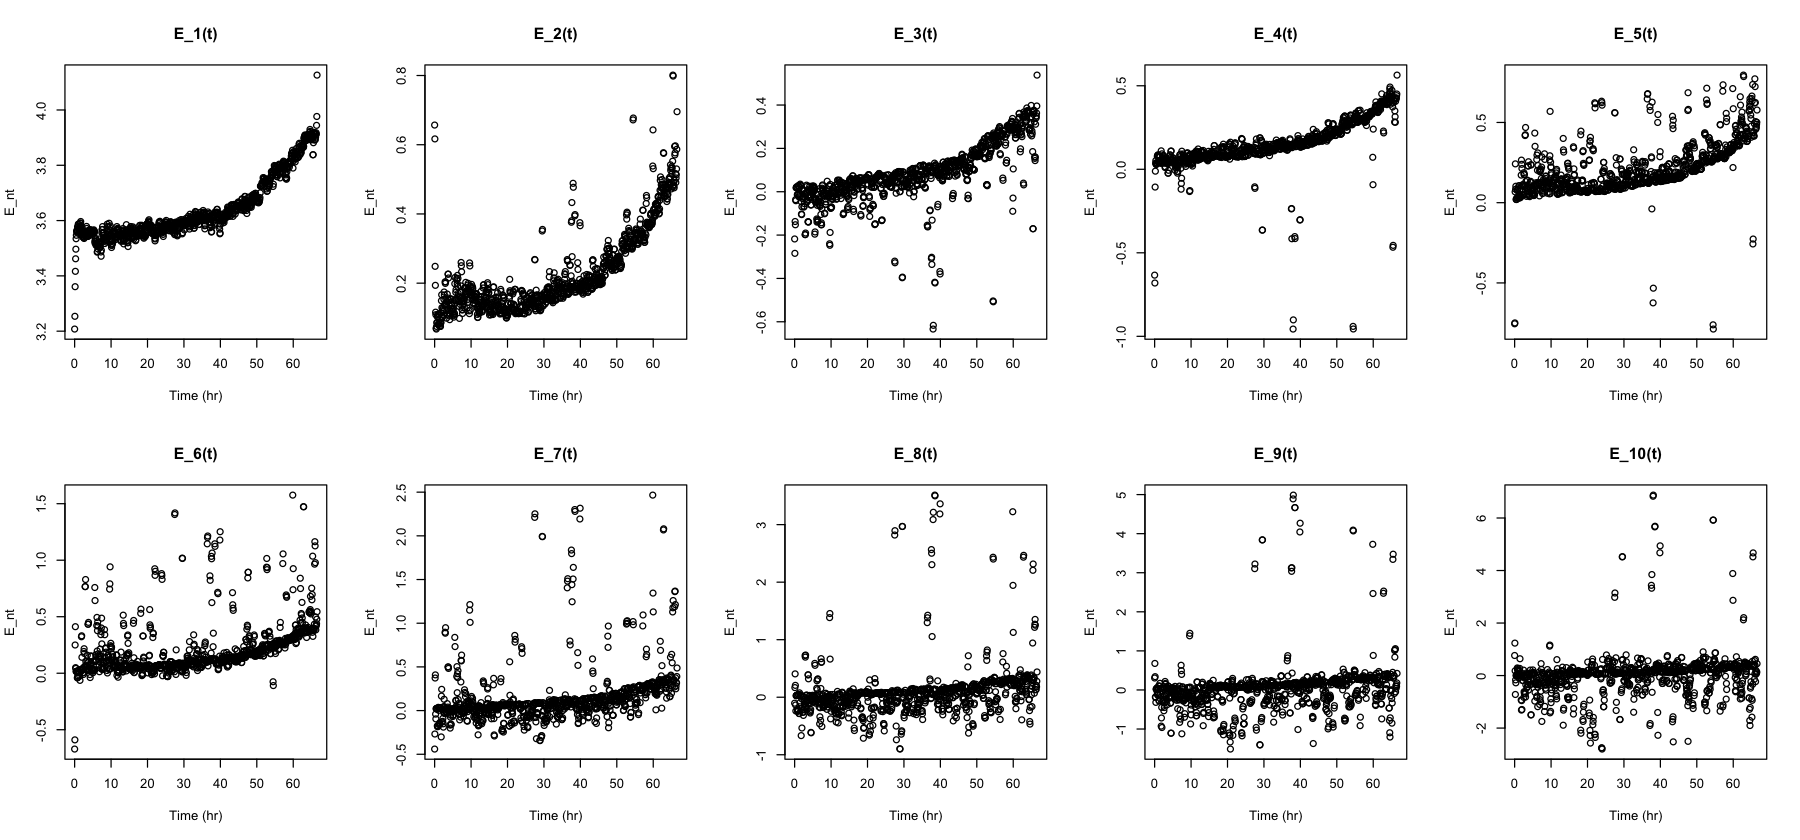

In [24]:
par(mfrow = c(2,5))

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_WT))
  plot(x = microMA_WT$time/60, 
       y = E_nt, 
       xlab = "Time (hr)",
       main = paste("E_", n, "(t)", sep = ""))
}

# sapply(1:5, log_choose, n=n, moments_expectations=moments_expectations_WT)

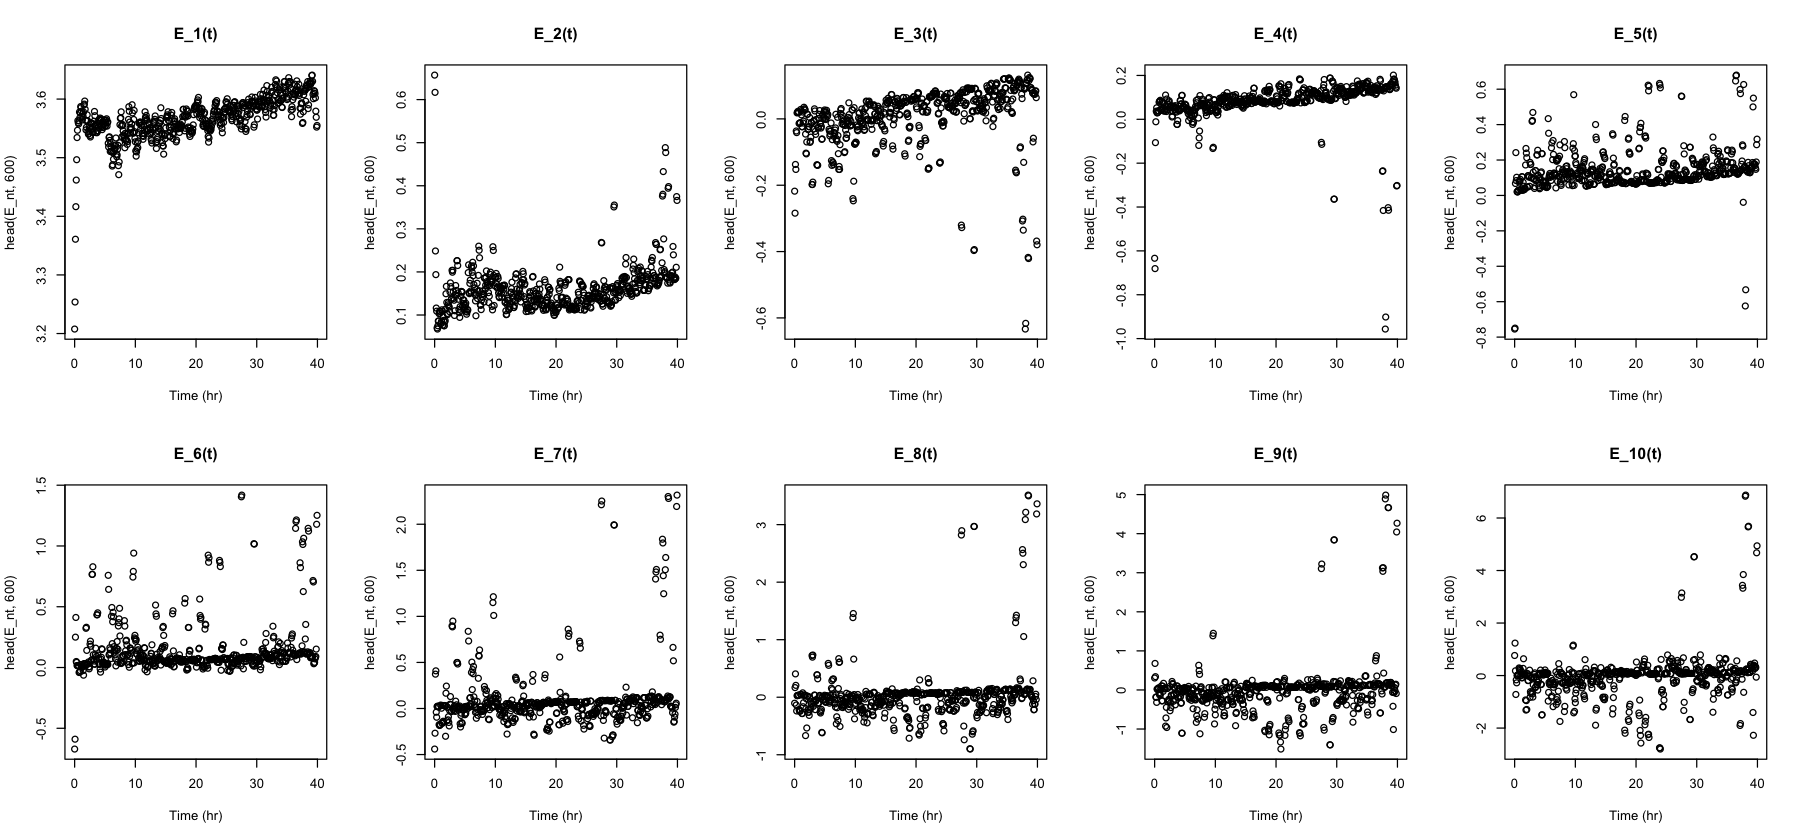

In [25]:
par(mfrow = c(2,5))

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_WT))
  plot(x = head(microMA_WT$time/60, 600), 
       y = head(E_nt, 600), 
       xlab = "Time (hr)",
       main = paste("E_", n, "(t)", sep = ""))
}

#### WT + MutH


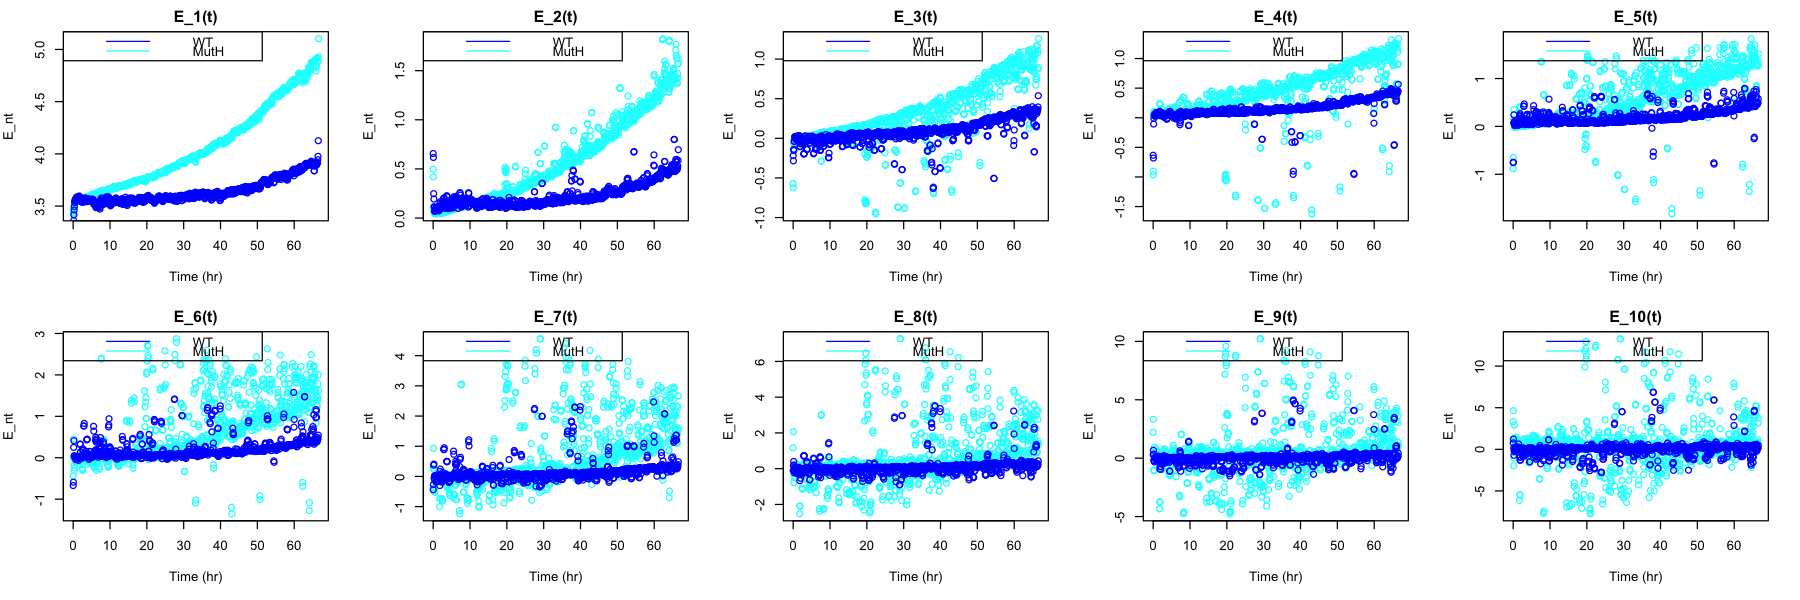

In [26]:
par(mfrow = c(2,5), mar = c(5, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 5)

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_MutH))
  plot(x = microMA_MutH$time/60, 
       y = E_nt,
       xlab = "Time (hr)",
       col = "cyan",
       main = paste("E_", n, "(t)", sep = ""))
  
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_WT))
  points(x = microMA_WT$time/60, 
       y = E_nt, 
       xlab = "Time (hr)",
       col = "blue",
       main = paste("E_", n, "(t)", sep = ""))
  
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=13)
}

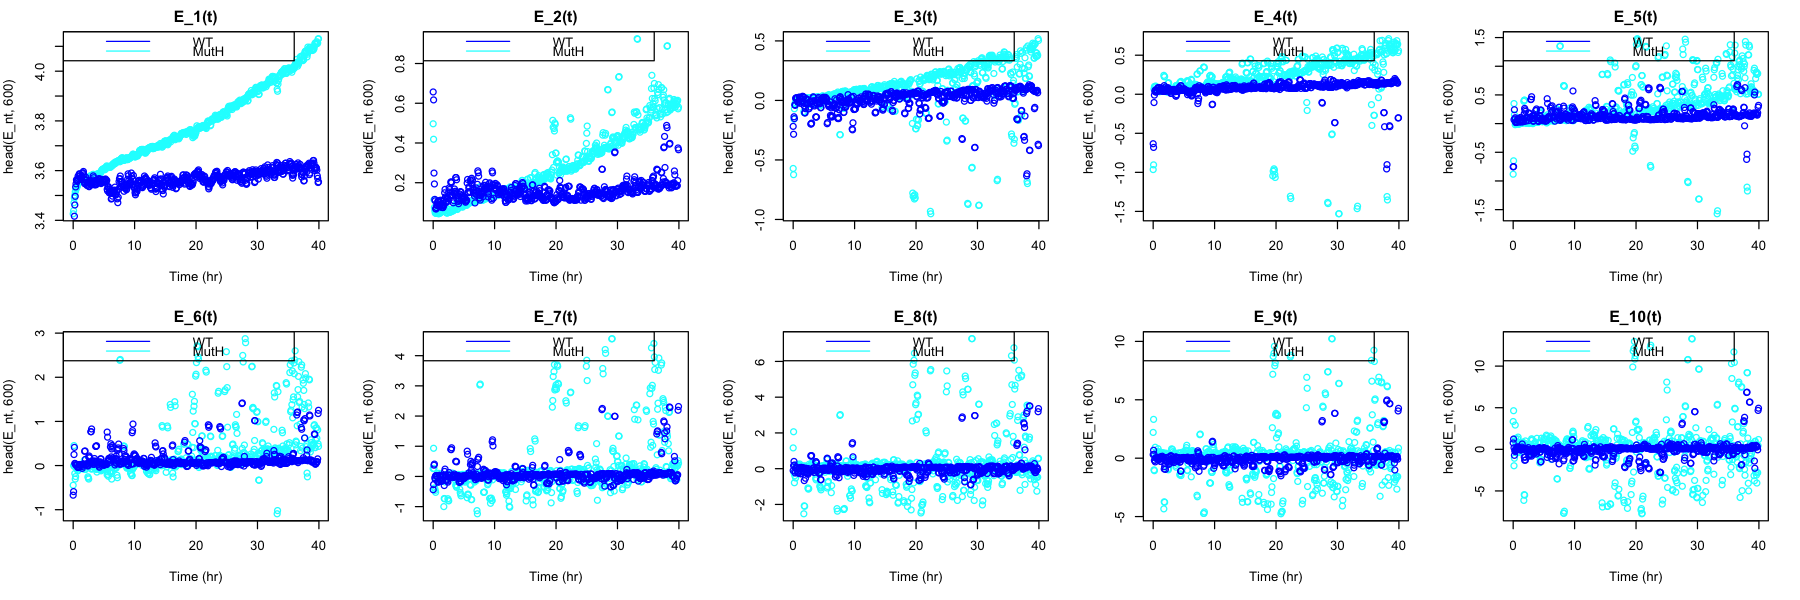

In [27]:
par(mfrow = c(2,5), mar = c(5, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 5)

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_MutH))
  plot(x = head(microMA_MutH$time/60, 600), 
       y = head(E_nt, 600), 
       xlab = "Time (hr)",
       col = "cyan",
       main = paste("E_", n, "(t)", sep = ""))
  
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_WT))
  points(x = head(microMA_WT$time/60, 600), 
       y = head(E_nt, 600), 
       xlab = "Time (hr)",
       col = "blue",
       main = paste("E_", n, "(t)", sep = ""))
  
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=13)
}

#### Correct aberrant growth rates

Plot some examples of growth rate evolution

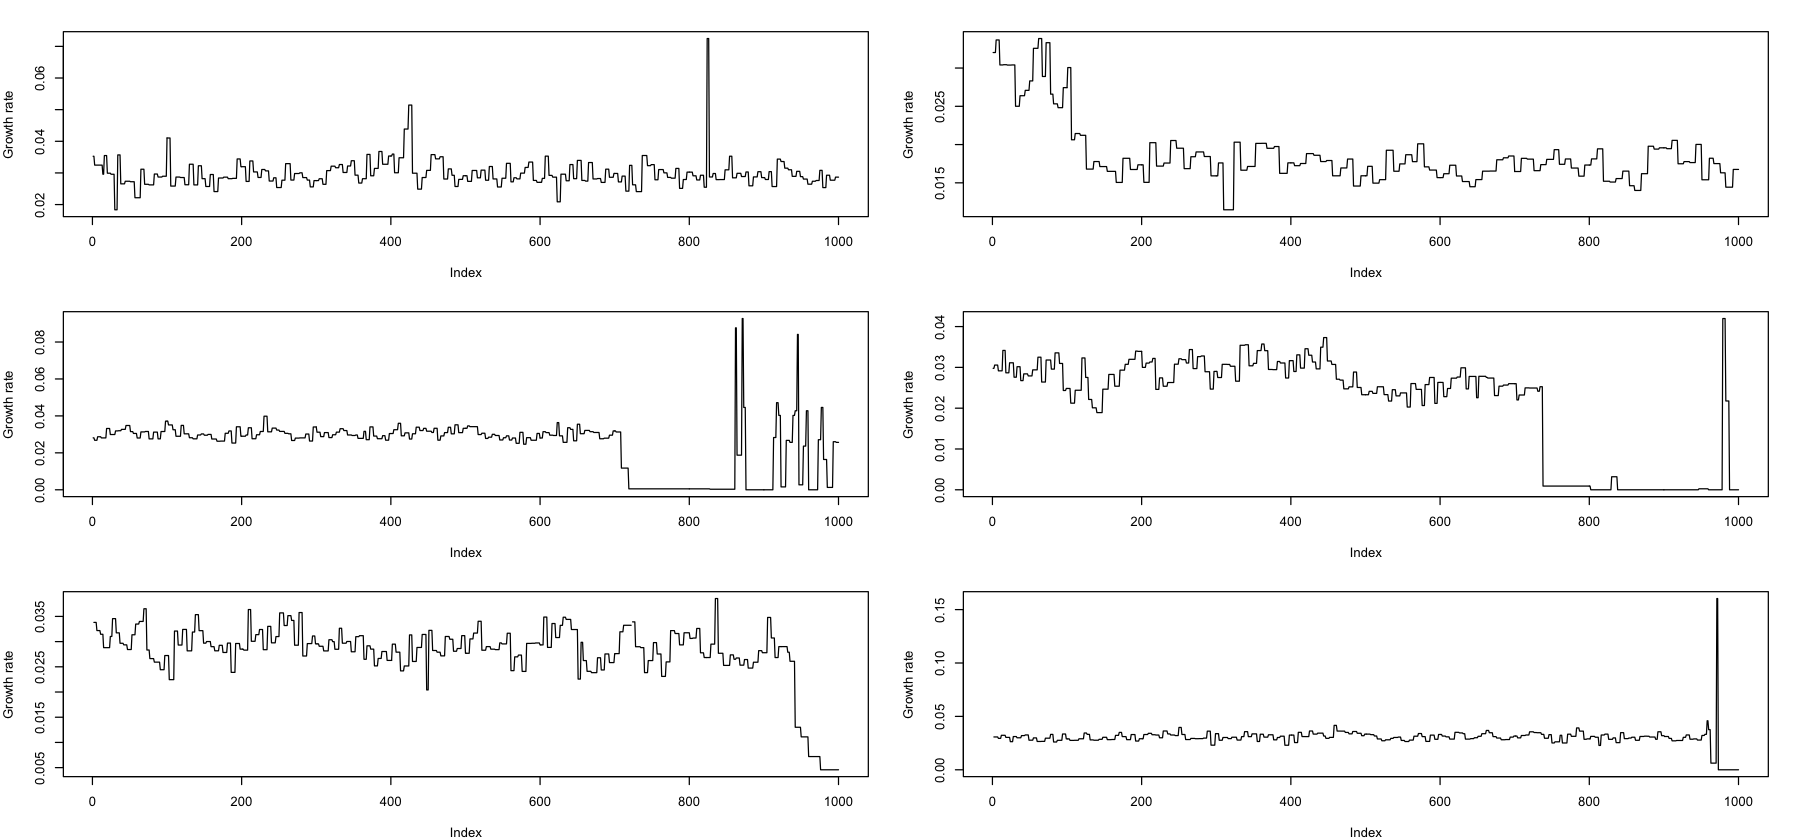

In [28]:
par(mfrow=c(3,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 7)

for (i in 1:6){
    plot(microMA_MutH_growthRates[,i], type="l", ylab = "Growth rate")
}

The segmentation errors generated by image analysis can create aberrant, very low or
high growth rates. Therefore, we filtered our data in the following way :
   1. For each channel and each generation, we calculated the median of the growth rates for earlier generations ($M_{before}$) and subsequent generations ($M_{after}$).
   <br/>$\to$ *Modification : take only the 100 earlier and subsequent generations*
   2. Growth rate estimates that are clearly aberrant (as confirmed by visual inspection of images) are either much larger than both $M_{before}$ and $M_{after}$ or much smaller than both $M_{before}$ and $M_{after}$.
   3. Therefore for each generation, we remove the value of the growth rate µ from the data if it differs from both $M_{after}$ and $M_{before}$ by more than a threshold value T.
   4. The value T was fixed at 30% of the average growth rate in the experiment, corresponding to the mean $\pm 2\times$standard deviation of the variable $\mu - M_{after}$
   5. The datasets for all strains (WT mutH, mutT,and MF1 such as plotted in Figure 3A and Figure S8)were all filtered using the same procedure.

In [29]:
detect_aberrant_GR <- function(i, L){
    mu <- L[i]
    
    if (i>1){
        M_before <- median(L[max(1,i-100):(i-1)], na.rm = T)
    }else{
        M_before <- mu
    }
    
    if (i<length(L)){
        M_after <- median(L[i+1:min(length(L),i+100)], na.rm = T)
    }else{
        M_after <- mu
    }
    
    T <- 0.3*mean(L, na.rm = T)
    
    if (anyNA(c(mu, M_before, M_after))){ return (TRUE) }
    
    return((mu - M_before > T & mu - M_after > T)|(mu - M_before < -T & mu - M_after < -T))
}

microMA_MutH_growthRates_non_aberrant <- microMA_MutH_growthRates
for (i in 1:dim(microMA_MutH_growthRates)[2]){
    L <- microMA_MutH_growthRates[,i]
    microMA_MutH_growthRates_non_aberrant[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}

Plot some examples of growth rate evolution, before and after removal of aberrant values

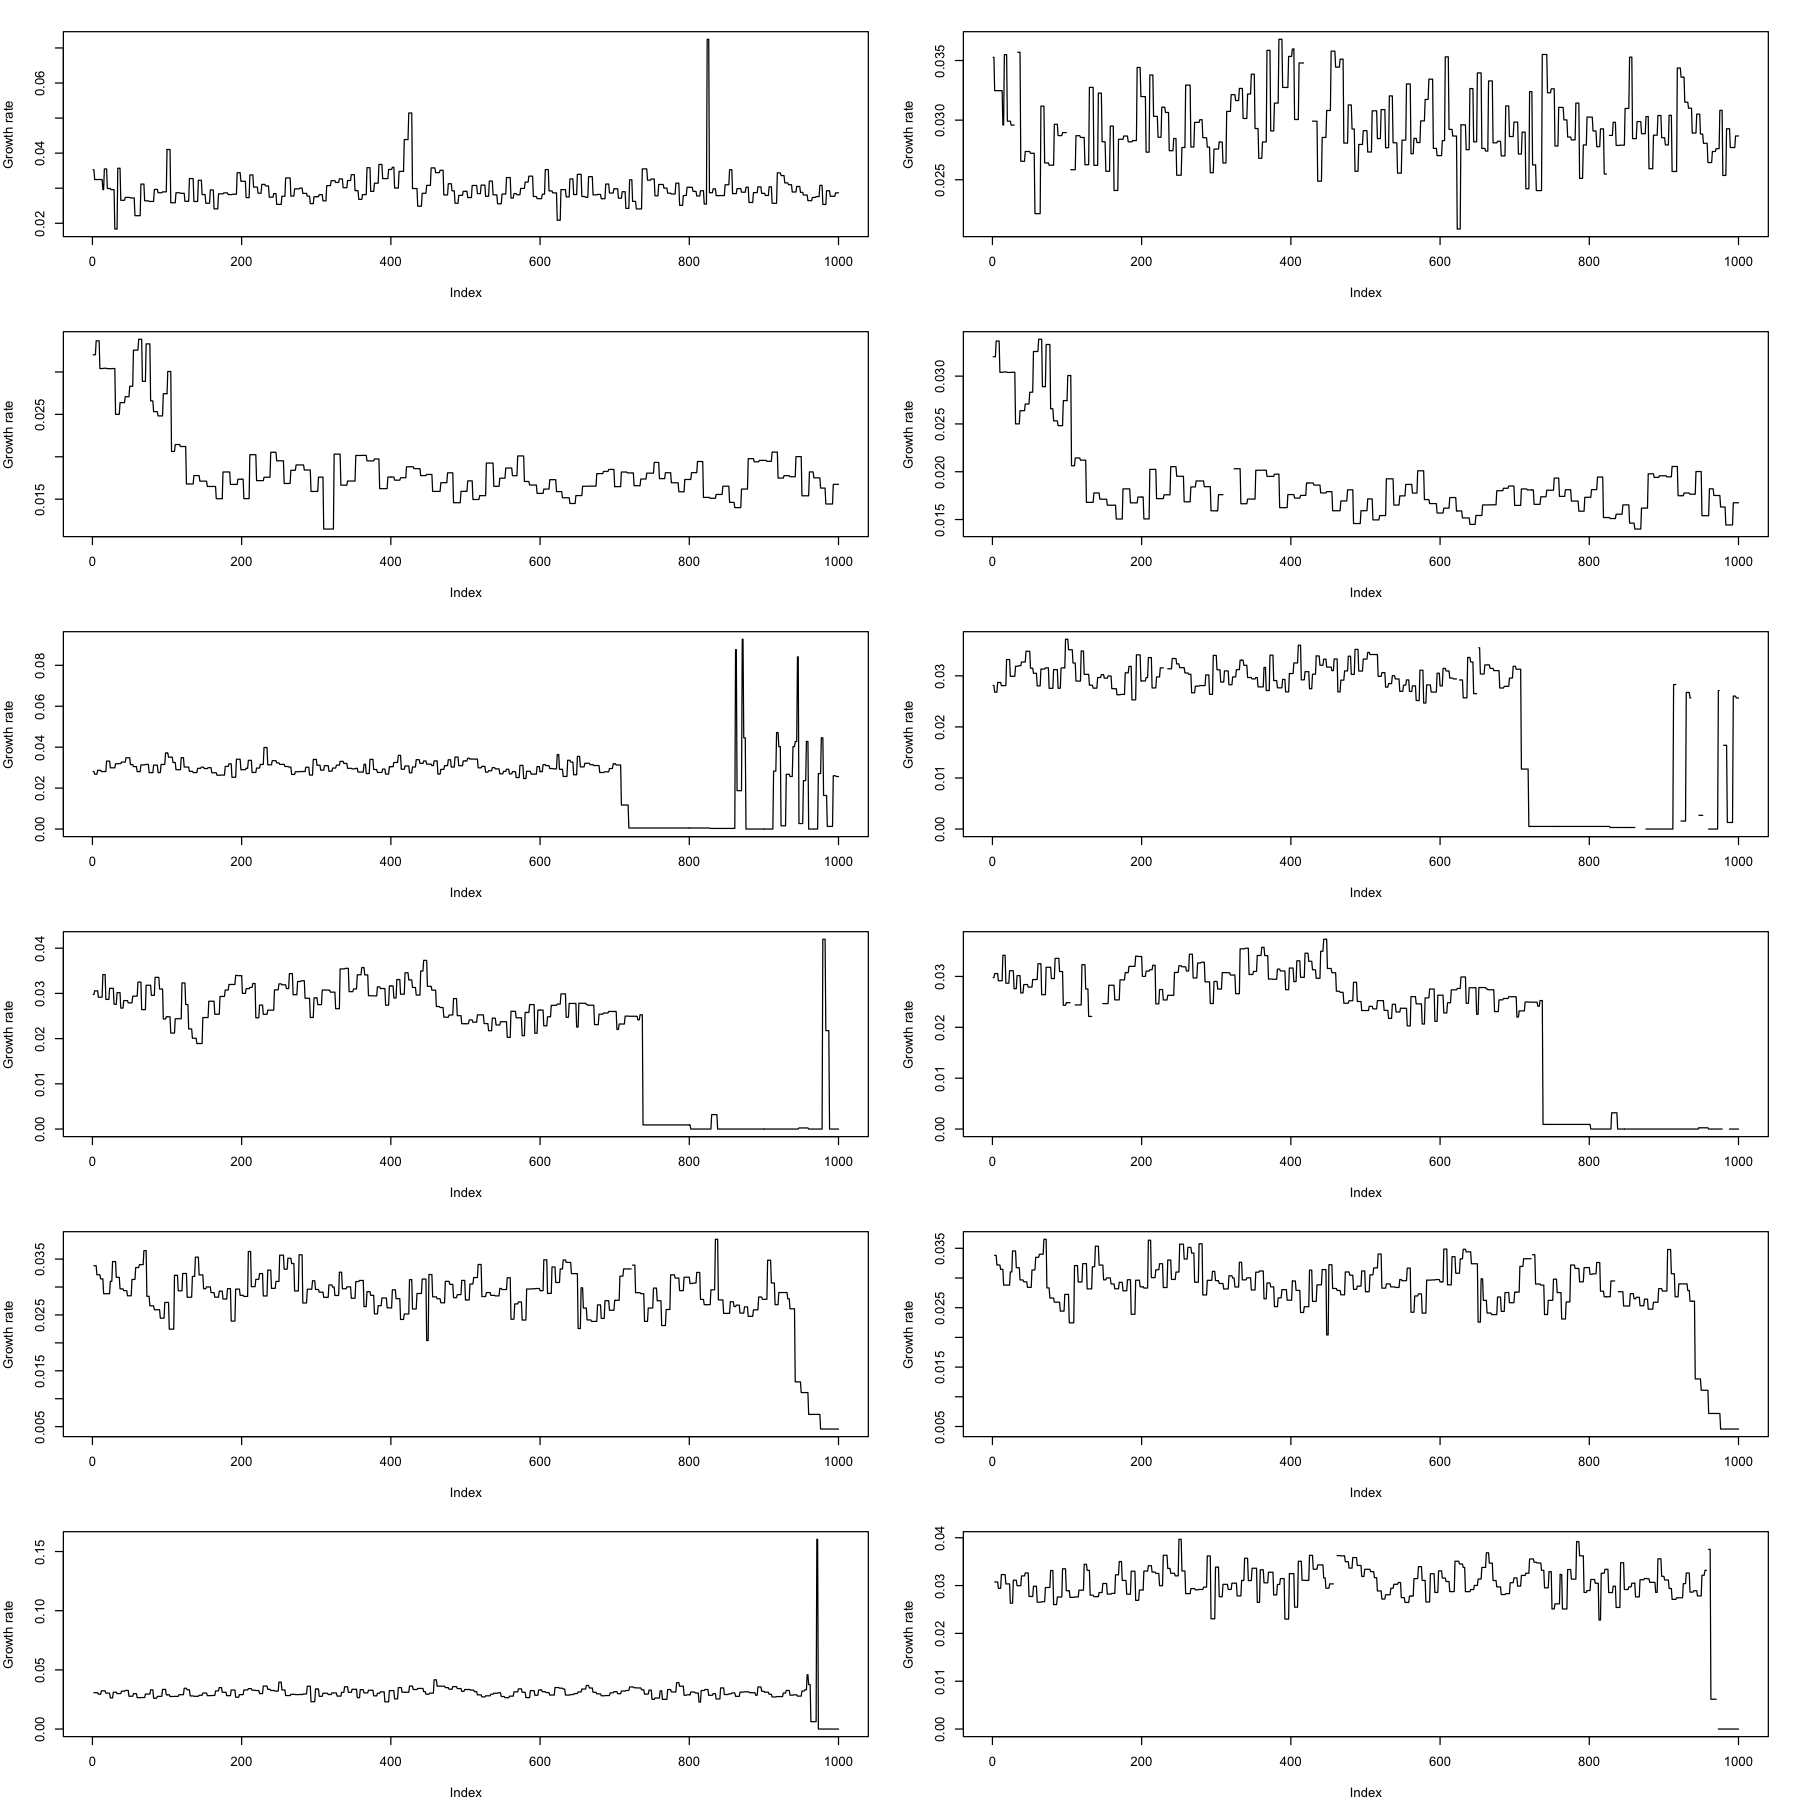

In [30]:
par(mfrow=c(6,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 15)

for (i in 1:6){
    plot(microMA_MutH_growthRates[, i], type="l", ylab = "Growth rate")
    plot(microMA_MutH_growthRates_non_aberrant[, i], type="l", ylab = "Growth rate")
}

In [31]:
moments_expectations_non_aberrant_MutH <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_MutH_growthRates_non_aberrant))
names(moments_expectations_non_aberrant_MutH) <- paste("k.", k_values, sep = "")

In [78]:
microMA_WT_growthRates_non_aberrant <- microMA_WT_growthRates
for (i in 1:dim(microMA_WT_growthRates)[2]){
    L <- microMA_WT_growthRates[,i]
    microMA_WT_growthRates_non_aberrant[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}

moments_expectations_non_aberrant_WT <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_WT_growthRates_non_aberrant))
names(moments_expectations_non_aberrant_WT) <- paste("k.", k_values, sep = "")

Plot the comparison between WT and MutH

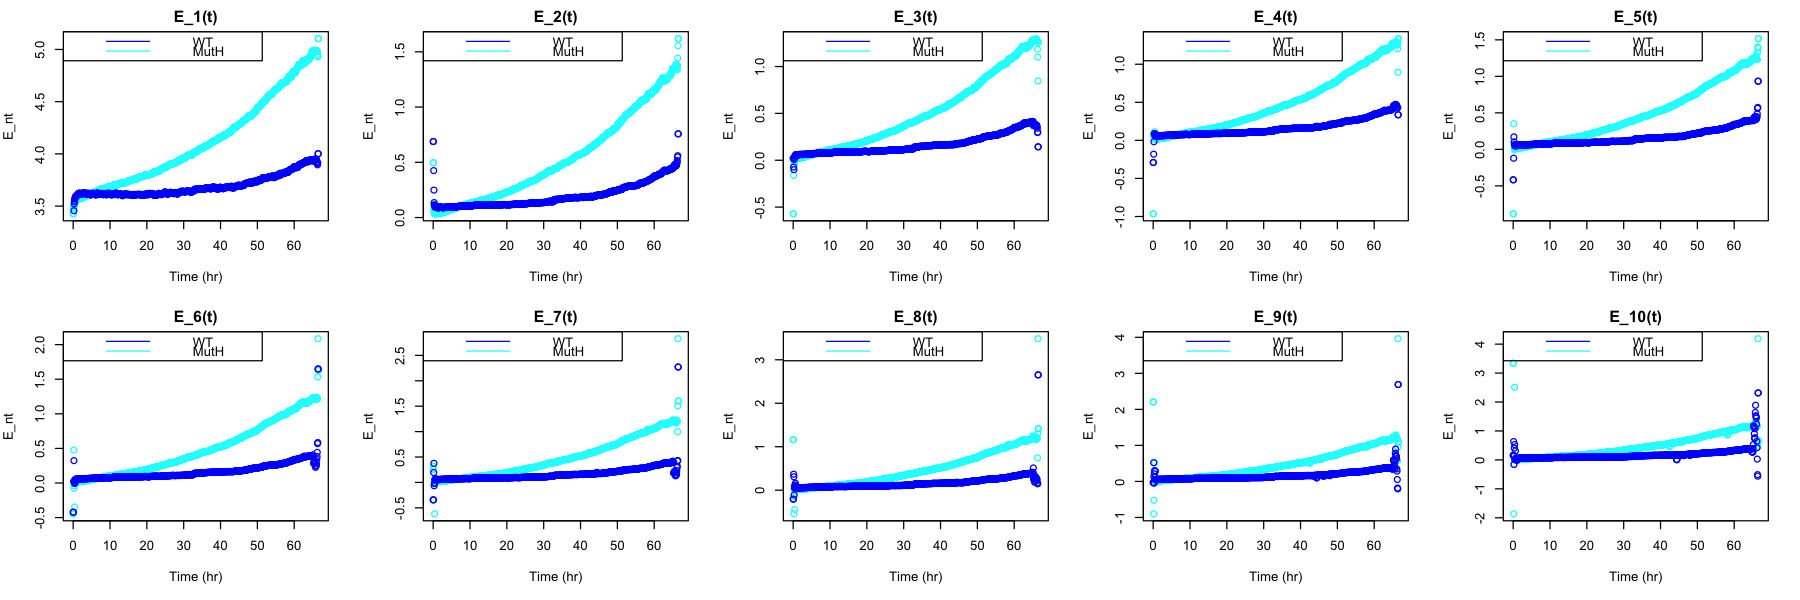

In [79]:
par(mfrow = c(2,5), mar = c(5, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 5)

for (n in 1:10){
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_non_aberrant_MutH))
  plot(x = microMA_MutH$time/60, 
       y = E_nt, 
       xlab = "Time (hr)",
       col = "cyan",
       main = paste("E_", n, "(t)", sep = ""))
  
  E_nt <- rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_non_aberrant_WT))
  points(x = microMA_WT$time/60, 
       y = E_nt, 
       xlab = "Time (hr)",
       col = "blue",
       main = paste("E_", n, "(t)", sep = ""))
  
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=13)
}

Death of slowly growing cells induces noise in DFE estimation. Therefore,
to estimate the DFE’s first moments we used a subset of the data :
   1. Restricted in time (time points before 40 hours)
   <br/>$\to$ *Modification : we also remove the first 40 minutes that are quite noisy*
   2. Containing only cells that do not die on this restricted time window (only channels where the mother cell is still alive at 44 hours). For selecting such data we use an automatic procedure. If the growth rate of a cell is below 0.003 (10% of its initial value) during more than 80 minutes, the cell and its potential descendants are removed from the data.

##### MutH

In [285]:
microMA_MutH_channels_GR <- microMA_MutH_channels[,1:round(dim(microMA_MutH_channels)[2]/3)*3]
microMA_MutH_channels_GR

growth.rate growth.rate.1 growth.rate.2 growth.rate.3 growth.rate.4
1 1            1             1             1             1           
2 1           10            11            12            13           
  growth.rate.5 growth.rate.6 growth.rate.7 growth.rate.8 growth.rate.9 ⋯
1  1             1            1             1             1             ⋯
2 14            15            2             3             4             ⋯
  growth.rate.1466 growth.rate.1467 growth.rate.1468 growth.rate.1469
1 100              100              100              100             
2  14               15                2                3             
  growth.rate.1470 growth.rate.1471 growth.rate.1472 growth.rate.1473
1 100              100              100              100             
2   4                5                6                7             
  growth.rate.1474 growth.rate.1475
1 100              100             
2   8                9

Get the final state and frame for each cell

In [286]:
microMA_MutH_final <- sapply(microMA_MutH_channels_GR, 
                             function(GR){mortality_MutH[mortality_MutH$Field.view == GR[1] &
                                                         mortality_MutH$Microchannel == GR[2], c(3,4)]})
microMA_MutH_final

growth.rate growth.rate.1 growth.rate.2 growth.rate.3 growth.rate.4
Final.state             2             1             1             2            
Final.frame             1000          717           739           1000         
            growth.rate.5 growth.rate.6 growth.rate.7 growth.rate.8
Final.state 1             2             4             4            
Final.frame 966           1000          441           346          
            growth.rate.9 ⋯ growth.rate.1466 growth.rate.1467 growth.rate.1468
Final.state 1             ⋯ 1                1                4               
Final.frame 402           ⋯ 780              510              47              
            growth.rate.1469 growth.rate.1470 growth.rate.1471 growth.rate.1472
Final.state 4                1                1                4               
Final.frame 528              653              113              426             
            growth.rate.1473 growth.rate.1474 growth.rate.1475
Final.state 1                2                1               
Final.frame 231              1000             524

***Remove data for dead or escaped cells***

In [287]:
microMA_MutH_growthRates_clean <- microMA_MutH_growthRates_non_aberrant

for (i in which(microMA_MutH_final["Final.state",]!=2)){
    microMA_MutH_growthRates_clean[microMA_MutH_final[["Final.frame",i]]:1000,i] <- NA
}

Plot some examples of growth rate evolution, before and after removal of aberrant values or dead cells

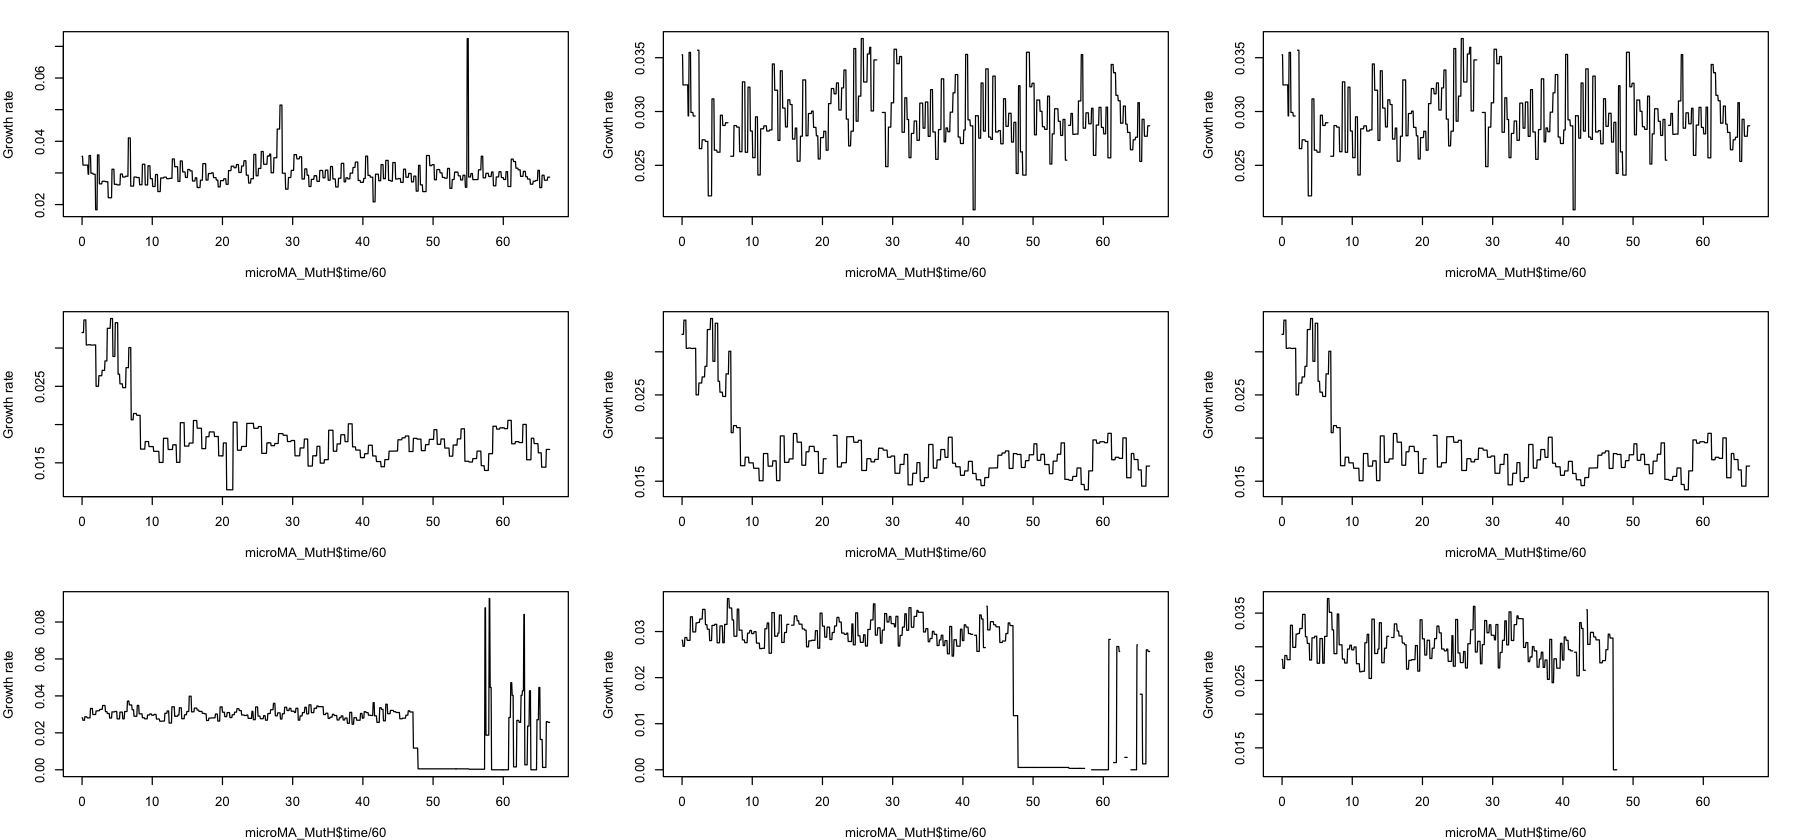

In [289]:
par(mfrow=c(3,3), mar = c(4, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 7)

for (i in 1:3){
    plot(x = microMA_MutH$time/60, microMA_MutH_growthRates[, i], type="l", ylab = "Growth rate")
    plot(x = microMA_MutH$time/60, microMA_MutH_growthRates_non_aberrant[, i], type="l", ylab = "Growth rate")
    plot(x = microMA_MutH$time/60, microMA_MutH_growthRates_clean[, i], type="l", ylab = "Growth rate")
}

***Keep only between 40 minutes and 40 hours***

In [290]:
time_window <- 10:600
microMA_MutH_growthRates_clean <- microMA_MutH_growthRates_clean[time_window,]

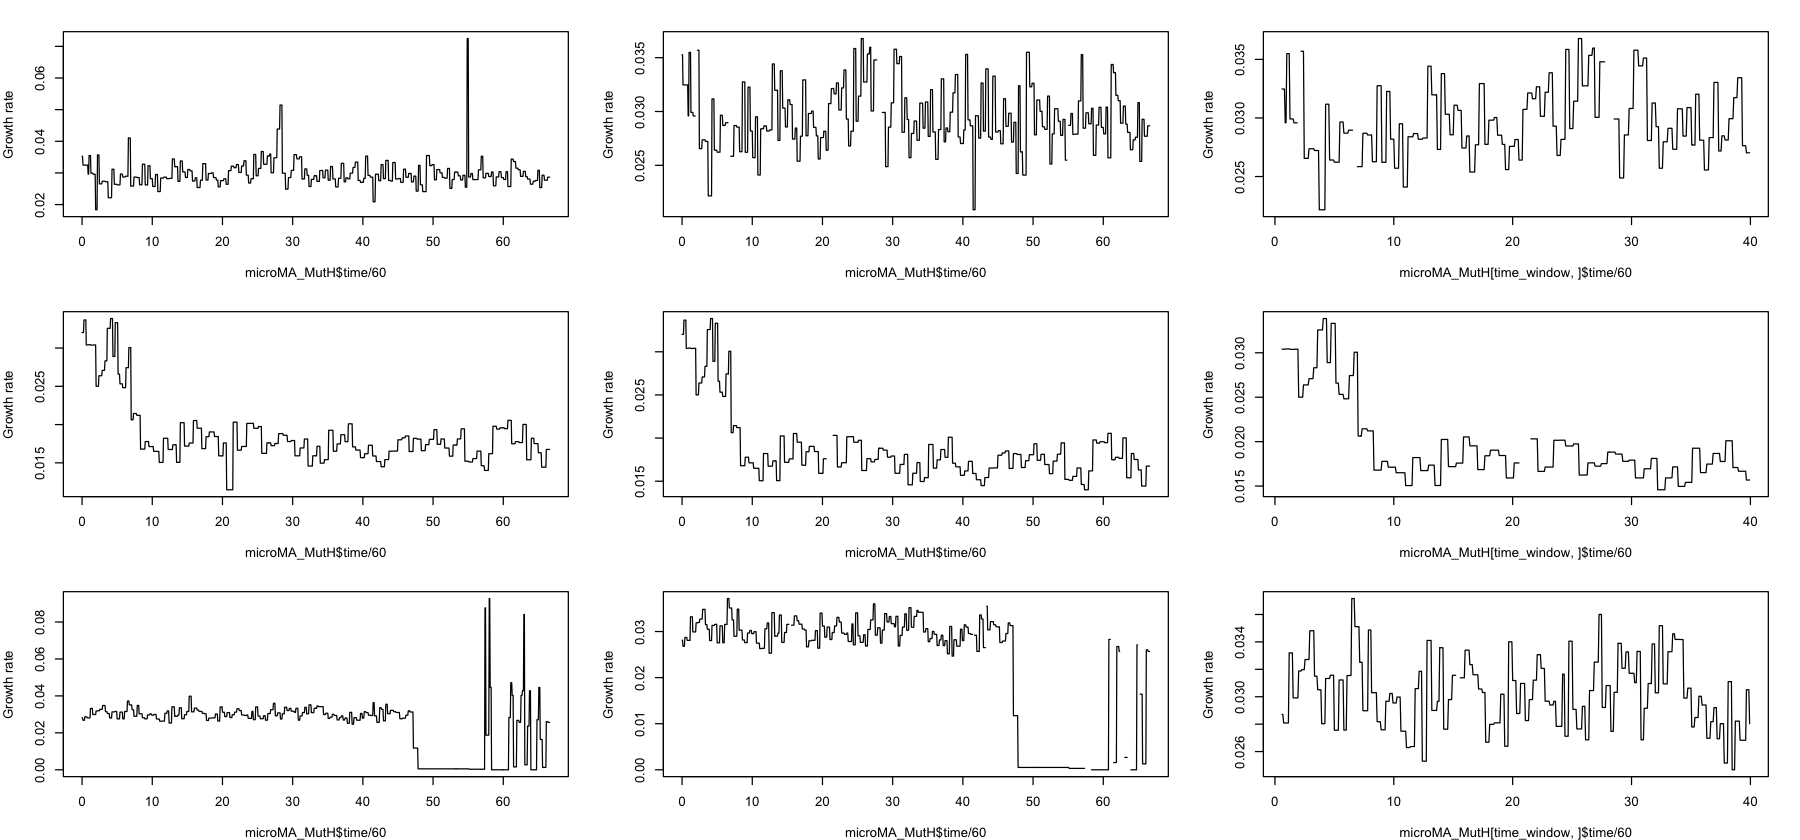

In [291]:
par(mfrow=c(3,3), mar = c(4, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 7)

for (i in 1:3){
    plot(x = microMA_MutH$time/60, microMA_MutH_growthRates[, i], type="l", ylab = "Growth rate")
    plot(x = microMA_MutH$time/60, microMA_MutH_growthRates_non_aberrant[, i], type="l", ylab = "Growth rate")
    plot(x = microMA_MutH[time_window,]$time/60, microMA_MutH_growthRates_clean[, i], type="l", ylab = "Growth rate")
}

In [292]:
moments_expectations_clean_MutH <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_MutH_growthRates_clean))
names(moments_expectations_clean_MutH) <- paste("k.", k_values, sep = "")

##### WT

In [293]:
microMA_WT_channels_GR <- microMA_WT_channels[,1:round(dim(microMA_WT_channels)[2]/3)*3]
microMA_WT_channels_GR

growth.rate growth.rate.1 growth.rate.2 growth.rate.3 growth.rate.4
1 1            1             1             1             1           
2 1           10            11            12            13           
  growth.rate.5 growth.rate.6 growth.rate.7 growth.rate.8 growth.rate.9 ⋯
1  1            1             1             1             1             ⋯
2 14            2             3             4             5             ⋯
  growth.rate.1241 growth.rate.1242 growth.rate.1243 growth.rate.1244
1 96               96               96               96              
2 13               14               15                2              
  growth.rate.1245 growth.rate.1246 growth.rate.1247 growth.rate.1248
1 96               96               96               96              
2  3                4                6                7              
  growth.rate.1249 growth.rate.1250
1 96               96              
2  8                9

Get the final state and frame for each cell

In [294]:
microMA_WT_final <- sapply(microMA_WT_channels_GR, 
                             function(GR){mortality_WT[mortality_WT$Field.view == GR[1] &
                                                         mortality_WT$Microchannel == GR[2], c(3,4)]})
microMA_WT_final

growth.rate growth.rate.1 growth.rate.2 growth.rate.3 growth.rate.4
Final.state             2             2             2             2            
Final.frame             999           999           999           999          
            growth.rate.5 growth.rate.6 growth.rate.7 growth.rate.8
Final.state 1             2             2             2            
Final.frame 619           999           999           999          
            growth.rate.9 ⋯ growth.rate.1241 growth.rate.1242 growth.rate.1243
Final.state 2             ⋯ 2                2                2               
Final.frame 999           ⋯ 999              999              999             
            growth.rate.1244 growth.rate.1245 growth.rate.1246 growth.rate.1247
Final.state 2                2                2                2               
Final.frame 999              999              999              999             
            growth.rate.1248 growth.rate.1249 growth.rate.1250
Final.state 1                2                2               
Final.frame 921              999              999

In [295]:
microMA_WT_growthRates_clean <- microMA_WT_growthRates_non_aberrant

# Remove data for dead or escaped cells
for (i in which(microMA_WT_final["Final.state",]!=2)){
    microMA_WT_growthRates_clean[microMA_WT_final[["Final.frame",i]]:999,i] <- NA
}

# Keep only between 40 minutes and 40 hours
microMA_WT_growthRates_clean <- microMA_WT_growthRates_clean[time_window,]

head(microMA_WT_growthRates_clean)

growth.rate growth.rate.1 growth.rate.2 growth.rate.3 growth.rate.4
12 0.02912119  0.03065654    0.03030216    0.02869543    0.02748972   
13 0.02912119  0.03065654            NA    0.02612103    0.02748972   
14 0.02912119  0.02454685            NA    0.02612103    0.02748972   
15 0.02930586  0.02454685            NA    0.02612103    0.02748972   
16 0.02930586  0.02454685            NA    0.02612103    0.02748972   
17 0.02930586  0.02454685            NA    0.02612103    0.02828868   
   growth.rate.5 growth.rate.6 growth.rate.7 growth.rate.8 growth.rate.9 ⋯
12 0.02761243    0.02677993    0.02413225    0.02690568    0.02743105    ⋯
13 0.02761243    0.02677993    0.02413225    0.02690568    0.02894806    ⋯
14 0.02761243    0.02677993    0.02413225    0.02690568    0.02894806    ⋯
15 0.02761243    0.02677993    0.02413225    0.03040030    0.02894806    ⋯
16 0.02761243    0.02775195    0.02413225    0.03040030    0.02894806    ⋯
17 0.02930278    0.02775195    0.02413225    0.03040030    0.02894806    ⋯
   growth.rate.1241 growth.rate.1242 growth.rate.1243 growth.rate.1244
12 0                0.002110901      0                0.02508472      
13 0                0.002110901      0                0.02508472      
14 0                0.002110901      0                0.02508472      
15 0                0.002110901      0                0.02508472      
16 0                0.002110901      0                0.02508472      
17 0                0.002110901      0                0.02508472      
   growth.rate.1245 growth.rate.1246 growth.rate.1247 growth.rate.1248
12 0.03014083       0.008097045              NA       0.02650800      
13         NA       0.008097045              NA               NA      
14 0.03610057       0.008097045              NA               NA      
15 0.03610057       0.008097045      0.02520488       0.02083694      
16 0.03610057       0.008097045      0.02520488       0.02083694      
17 0.03610057       0.008097045      0.02520488       0.02083694      
   growth.rate.1249 growth.rate.1250
12 0.02147257       0.03148445      
13 0.02147257       0.03148445      
14 0.02147257       0.03148445      
15 0.02147257       0.02476372      
16 0.02147257       0.02476372      
17 0.02147257       0.02476372

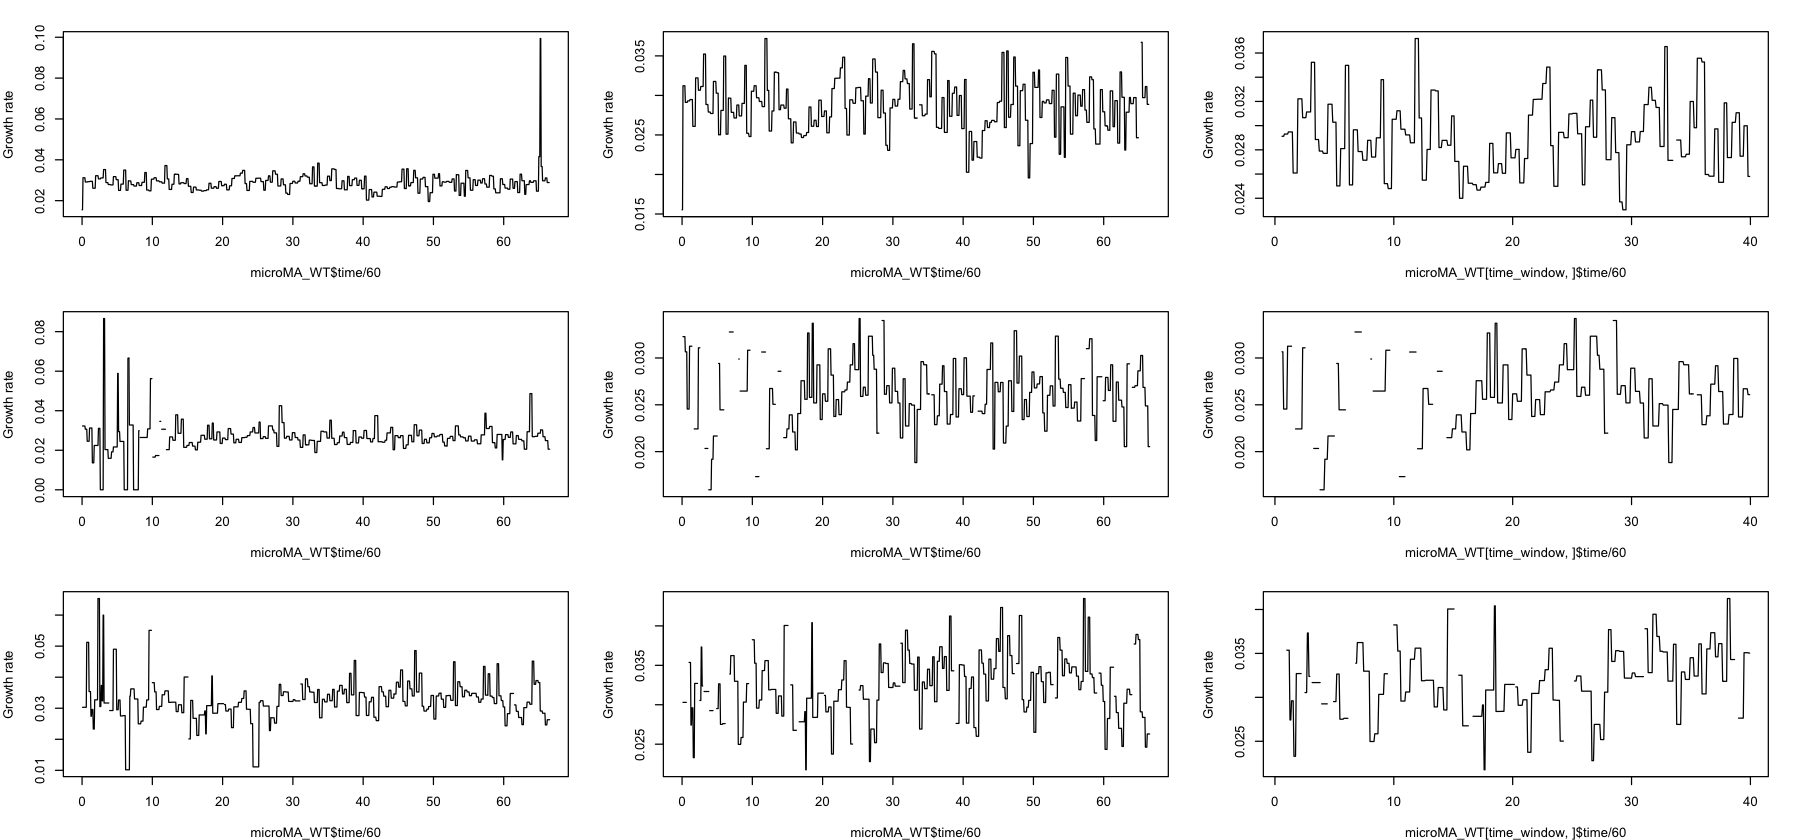

In [298]:
par(mfrow=c(3,3), mar = c(4, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 7)

for (i in 1:3){
    plot(x = microMA_WT$time/60, microMA_WT_growthRates[, i], type="l", ylab = "Growth rate")
    plot(x = microMA_WT$time/60, microMA_WT_growthRates_non_aberrant[, i], type="l", ylab = "Growth rate")
    plot(x = microMA_WT[time_window,]$time/60, microMA_WT_growthRates_clean[, i], type="l", ylab = "Growth rate")
}

In [296]:
moments_expectations_clean_WT <- data.frame(sapply(k_values, moment_expectation, dataset=microMA_WT_growthRates_clean))
names(moments_expectations_clean_WT) <- paste("k.", k_values, sep = "")

##### WT + MutH

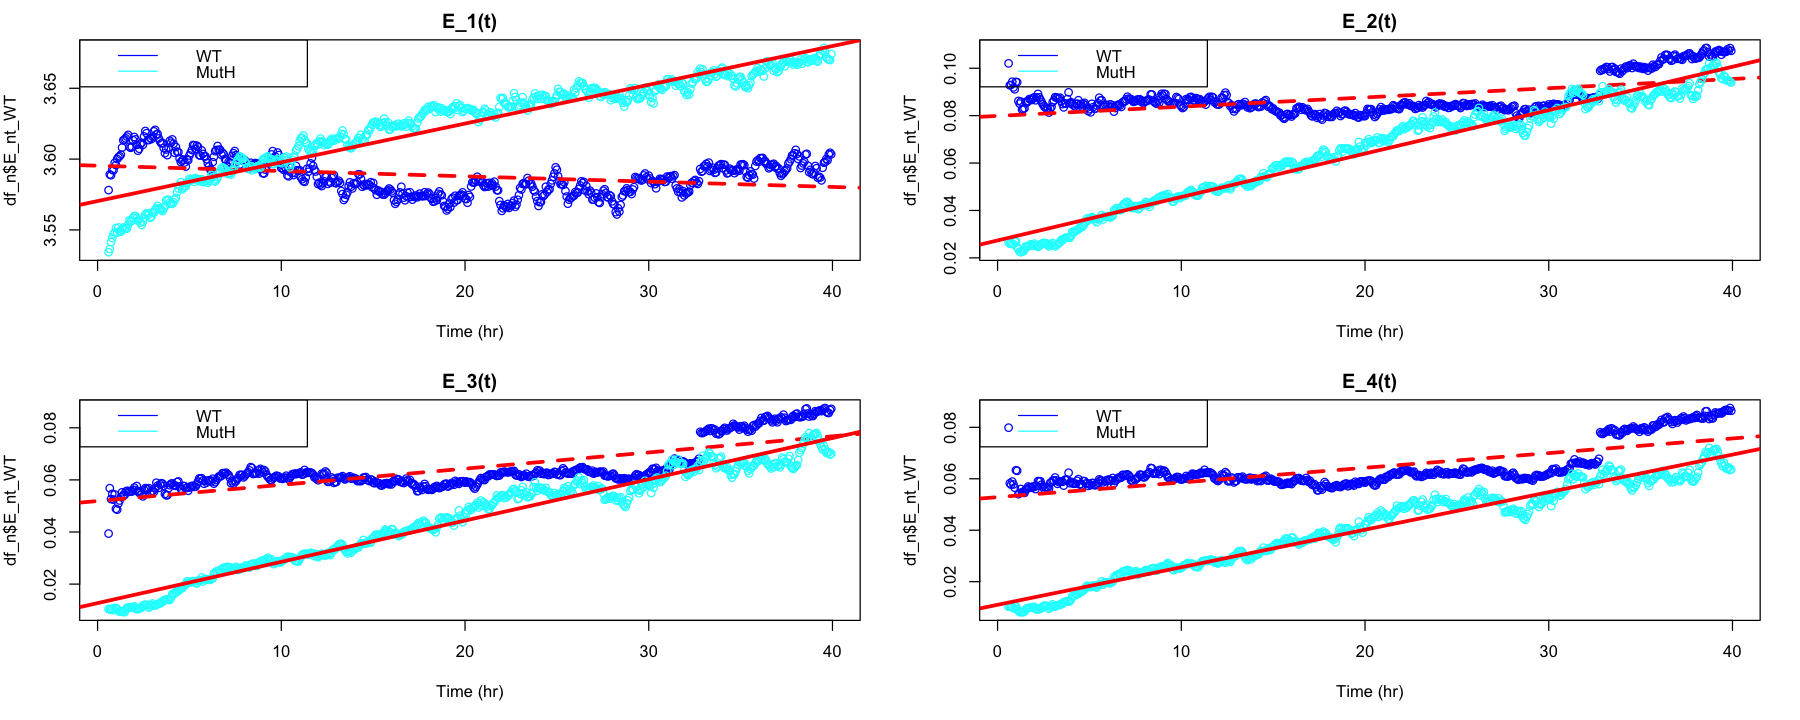

In [301]:
par(mfrow = c(2,2), mar = c(5, 4, 2, 2))
options(repr.plot.width = 15, repr.plot.height = 6)

N <- 4
slopes <- data.frame(n = 1:N,
                     slope_MutH = rep(NA,N), std_err_MutH = rep(NA,N), r_squared_MutH = rep(NA,N), 
                     slope_WT = rep(NA,N), std_err_WT = rep(NA,N), r_squared_WT = rep(NA,N))

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                     E_nt_WT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_WT)),
                     E_nt_MutH = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutH)))
    
    plot(x = df_n$time, 
         y = df_n$E_nt_WT, 
         xlab = "Time (hr)",
         col = "blue",
         main = paste("E_", n, "(t)", sep = ""),
         ylim = range(df_n[,c(2,3)]))
    
    lin_reg_WT <- lm(E_nt_WT~time, data=df_n)
    abline(lin_reg_WT, col="red", lty=2, lwd=3)
    slopes[n,2:4] <- c(summary(lin_reg_WT)$coefficients[2,c(1,2)], summary(lin_reg_MutH)$r.squared)
  
    points(x = df_n$time, 
           y = df_n$E_nt_MutH, 
           xlab = "Time (hr)",
           col = "cyan",
           main = paste("E_", n, "(t)", sep = ""))
    
    lin_reg_MutH <- lm(E_nt_MutH~time, data=df_n)
    abline(lin_reg_MutH, col="red", lwd=3)
    slopes[n,5:7] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)], summary(lin_reg_MutH)$r.squared)
    
  legend("topleft", legend = c("WT", "MutH"), col=c("blue", "cyan"), lty=1, seg.len = 1, text.width=5)
}

In [302]:
slopes

n slope_MutH    std_err_MutH r_squared_MutH slope_WT    std_err_WT  
1 1 -0.0003744835 4.321914e-05 0.9630316      0.002737476 3.370179e-05
2 2  0.0003895449 2.302712e-05 0.9180434      0.001833155 1.426372e-05
3 3  0.0006215895 2.006046e-05 0.9655677      0.001585434 1.246280e-05
4 4  0.0005704928 2.050267e-05 0.9648824      0.001460072 1.178723e-05
  r_squared_WT
1 0.9180434   
2 0.9655677   
3 0.9648824   
4 0.9630316

## Mutation Visualization experiment : data_MV

### Files description

"interarrival_times_figure2" gives the inter-arrival times between successive foci (in minutes) for a mutH experiment

inter_time
1  0        
2  8        
3 12        
4  4        
5 12        
6  8

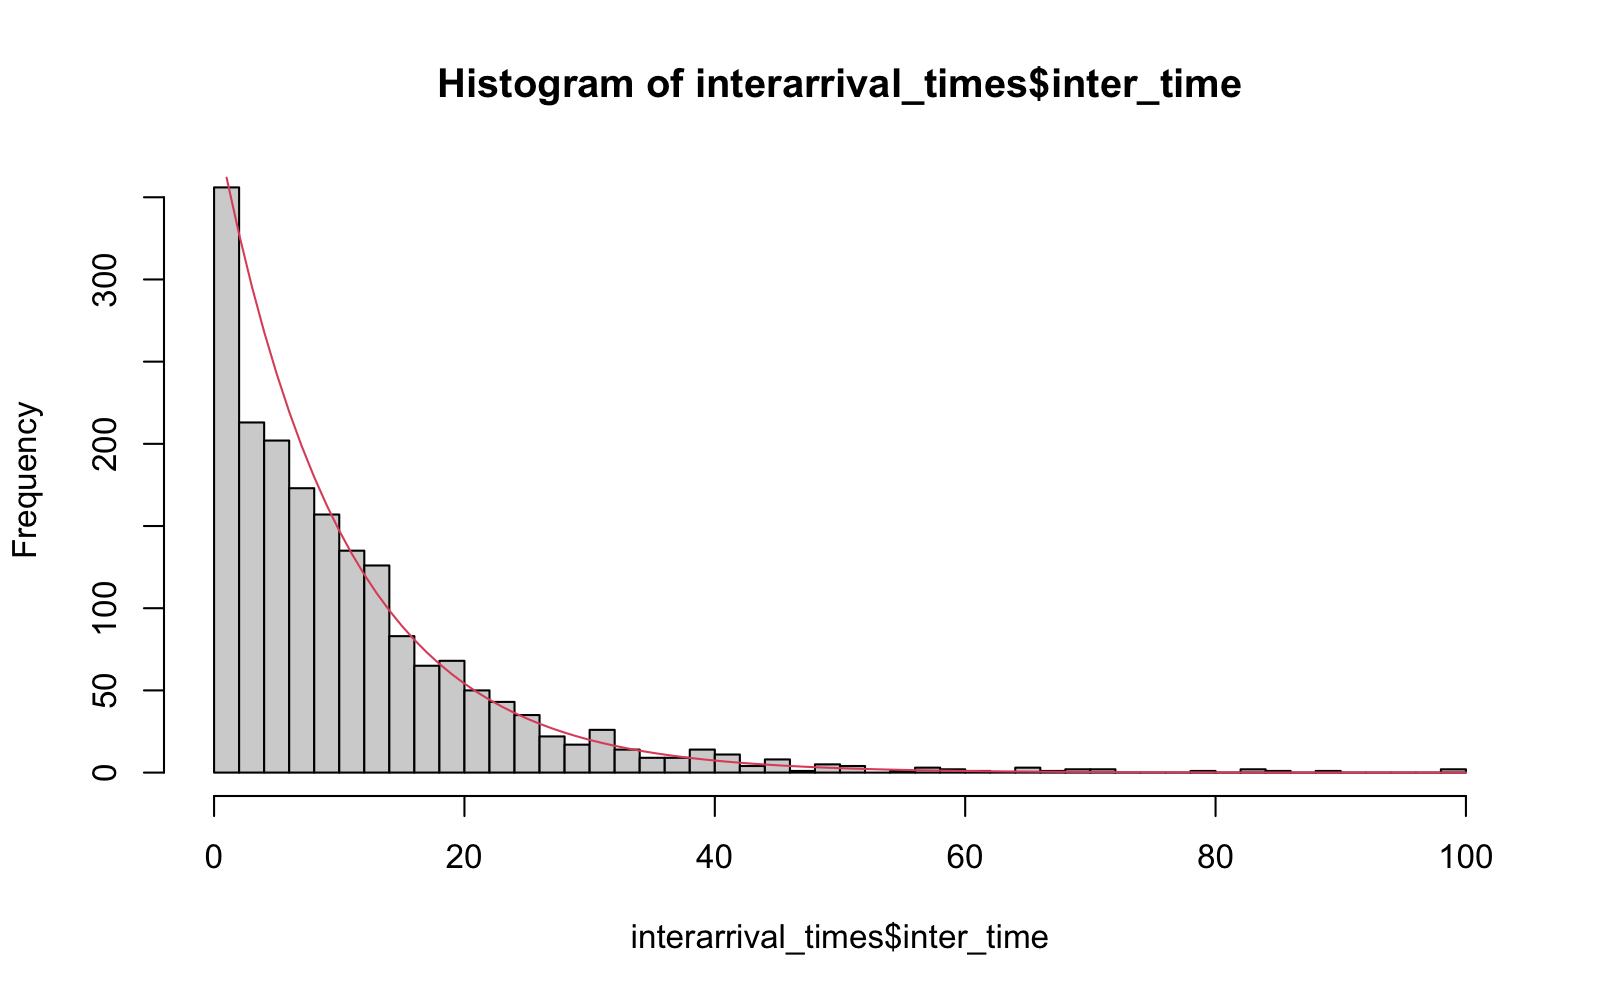

In [26]:
interarrival_times <- read.csv2("doi_10/All_data/data_MV/interarrival_times_figure2.csv")
names(interarrival_times) <- c("inter_time")
head(interarrival_times)
hist(interarrival_times$inter_time,breaks=40)

x=1:100
y=sapply(x,function(x) 400*exp(-0.1*x))
lines(x,y,col=2)


"size_and_focusfirstdetection_figure2E" gives the size and number of new foci for all mother cells at all times, for a mutH experiment (number new foci at time ti = number of foci that arose between ti-1 and ti)


In [27]:
size_nfoci <- read.csv2("./doi_10/All_data/data_MV/size_and_focusfirstdetection_figure2E.csv")
names(size_nfoci)=c("cell_size","nfoci")
head(size_nfoci)
summary(size_nfoci)

cell_size nfoci
1 2.9968    0    
2 3.1351    0    
3 3.3530    0    
4 3.5081    0    
5 3.7177    0    
6 4.0362    0

   cell_size          nfoci        
 Min.   : 2.578   Min.   :0.00000  
 1st Qu.: 3.424   1st Qu.:0.00000  
 Median : 4.053   Median :0.00000  
 Mean   : 4.220   Mean   :0.09278  
 3rd Qu.: 4.832   3rd Qu.:0.00000  
 Max.   :22.302   Max.   :3.00000  

In [28]:
sum(size_nfoci$nfoci==1)
sum(size_nfoci$nfoci==2)
sum(size_nfoci$nfoci==3)

[1] 7060

[1] 195

[1] 3

$\to$ We may forget cells with 2 foci or more (for the MutH experiment)

" size_growthrate_focusfirstdetection_figure2G" gives the size, growth rate and number of new foci for all mother cells at all times, for  mutH (2 experiments are pooled; number new foci at time ti = number of foci that arose between ti-1 and ti)


In [29]:
size_grate_nfoci<-read.csv2("doi_10/All_data/data_MV/size_growthrate_focusfirstdetection_figure2G.csv")

names(size_grate_nfoci)=c("size","grate","nfoci")
head(size_grate_nfoci)
summary(size_grate_nfoci)

size   grate      nfoci
1 5.4151 0.02826265 0    
2 2.8794 0.02875155 0    
3 2.9968 0.02875155 0    
4 3.1351 0.02875155 0    
5 3.3530 0.02875155 0    
6 3.5081 0.02875155 0

      size             grate               nfoci       
 Min.   : 0.7502   Min.   :0.0001932   Min.   :0.0000  
 1st Qu.: 3.3111   1st Qu.:0.0211233   1st Qu.:0.0000  
 Median : 4.0404   Median :0.0251375   Median :0.0000  
 Mean   : 4.3201   Mean   :0.0232383   Mean   :0.0805  
 3rd Qu.: 4.9499   3rd Qu.:0.0273565   3rd Qu.:0.0000  
 Max.   :24.2004   Max.   :0.0334957   Max.   :4.0000  

In [30]:
sum(size_nfoci$nfoci==1)
sum(size_nfoci$nfoci==2)
sum(size_nfoci$nfoci==3)

[1] 7060

[1] 195

[1] 3

# Data Analysis

## Stepwise growth rate drops

In [132]:
dim(microMA_MutH_growthRates)
head(microMA_MutH_growthRates)

[1] 1000 1476

growth.rate growth.rate.1 growth.rate.2 growth.rate.3 growth.rate.4
3 0.03526965  0.03202591    0.02811950    0.02976484            NA   
4 0.03526965  0.03202591    0.02811950    0.02976484    0.03381196   
5 0.03247045  0.03202591    0.02680181    0.03056693    0.03381196   
6 0.03247045  0.03202591    0.02680181    0.03056693    0.03381196   
7 0.03247045  0.03367152    0.02680181    0.03056693    0.03381196   
8 0.03247045  0.03367152    0.02680181    0.03056693    0.03219097   
  growth.rate.5 growth.rate.6 growth.rate.7 growth.rate.8 growth.rate.9 ⋯
3         NA    0.03168793    0.02793259    0.03028918          NA      ⋯
4 0.03075045    0.03168793    0.02793259    0.03028918    0.031277      ⋯
5 0.03075045    0.02882748    0.02793259    0.03028918    0.031277      ⋯
6 0.03075045    0.02882748    0.02793259    0.03254053    0.031277      ⋯
7 0.03075045    0.02882748    0.02793259    0.03254053    0.031277      ⋯
8 0.03075045    0.02882748    0.03294330    0.03254053    0.031277      ⋯
  growth.rate.1466 growth.rate.1467 growth.rate.1468 growth.rate.1469
3 0.03587815       0.02894183       0.02520117       0.02518458      
4 0.03587815       0.02894183       0.02520117       0.02518458      
5 0.03587815       0.02894183       0.02801961       0.02518458      
6 0.03587815       0.02894183       0.02801961       0.02518458      
7 0.03587815       0.02889316       0.02801961       0.02518458      
8 0.02884166       0.02889316       0.02801961       0.02901908      
  growth.rate.1470 growth.rate.1471 growth.rate.1472 growth.rate.1473
3 0.03095417       0.02421246       0.02599743       0.02345469      
4 0.03095417       0.02421246       0.02599743       0.02345469      
5 0.03095417       0.02956266       0.03209927       0.02662032      
6 0.03095417       0.02956266       0.03209927       0.02662032      
7 0.02644476       0.02956266       0.03209927       0.02662032      
8 0.02644476       0.02956266       0.03209927       0.02662032      
  growth.rate.1474 growth.rate.1475
3 0.01875880               NA      
4 0.01875880       0.02556724      
5 0.03087609       0.02556724      
6 0.03087609       0.02556724      
7 0.03087609       0.02556724      
8 0.03087609       0.02556724

### Gross drops : s=W'-W

[1] 176954

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -0.636  -0.003   0.000   0.000   0.003   0.636    3316 

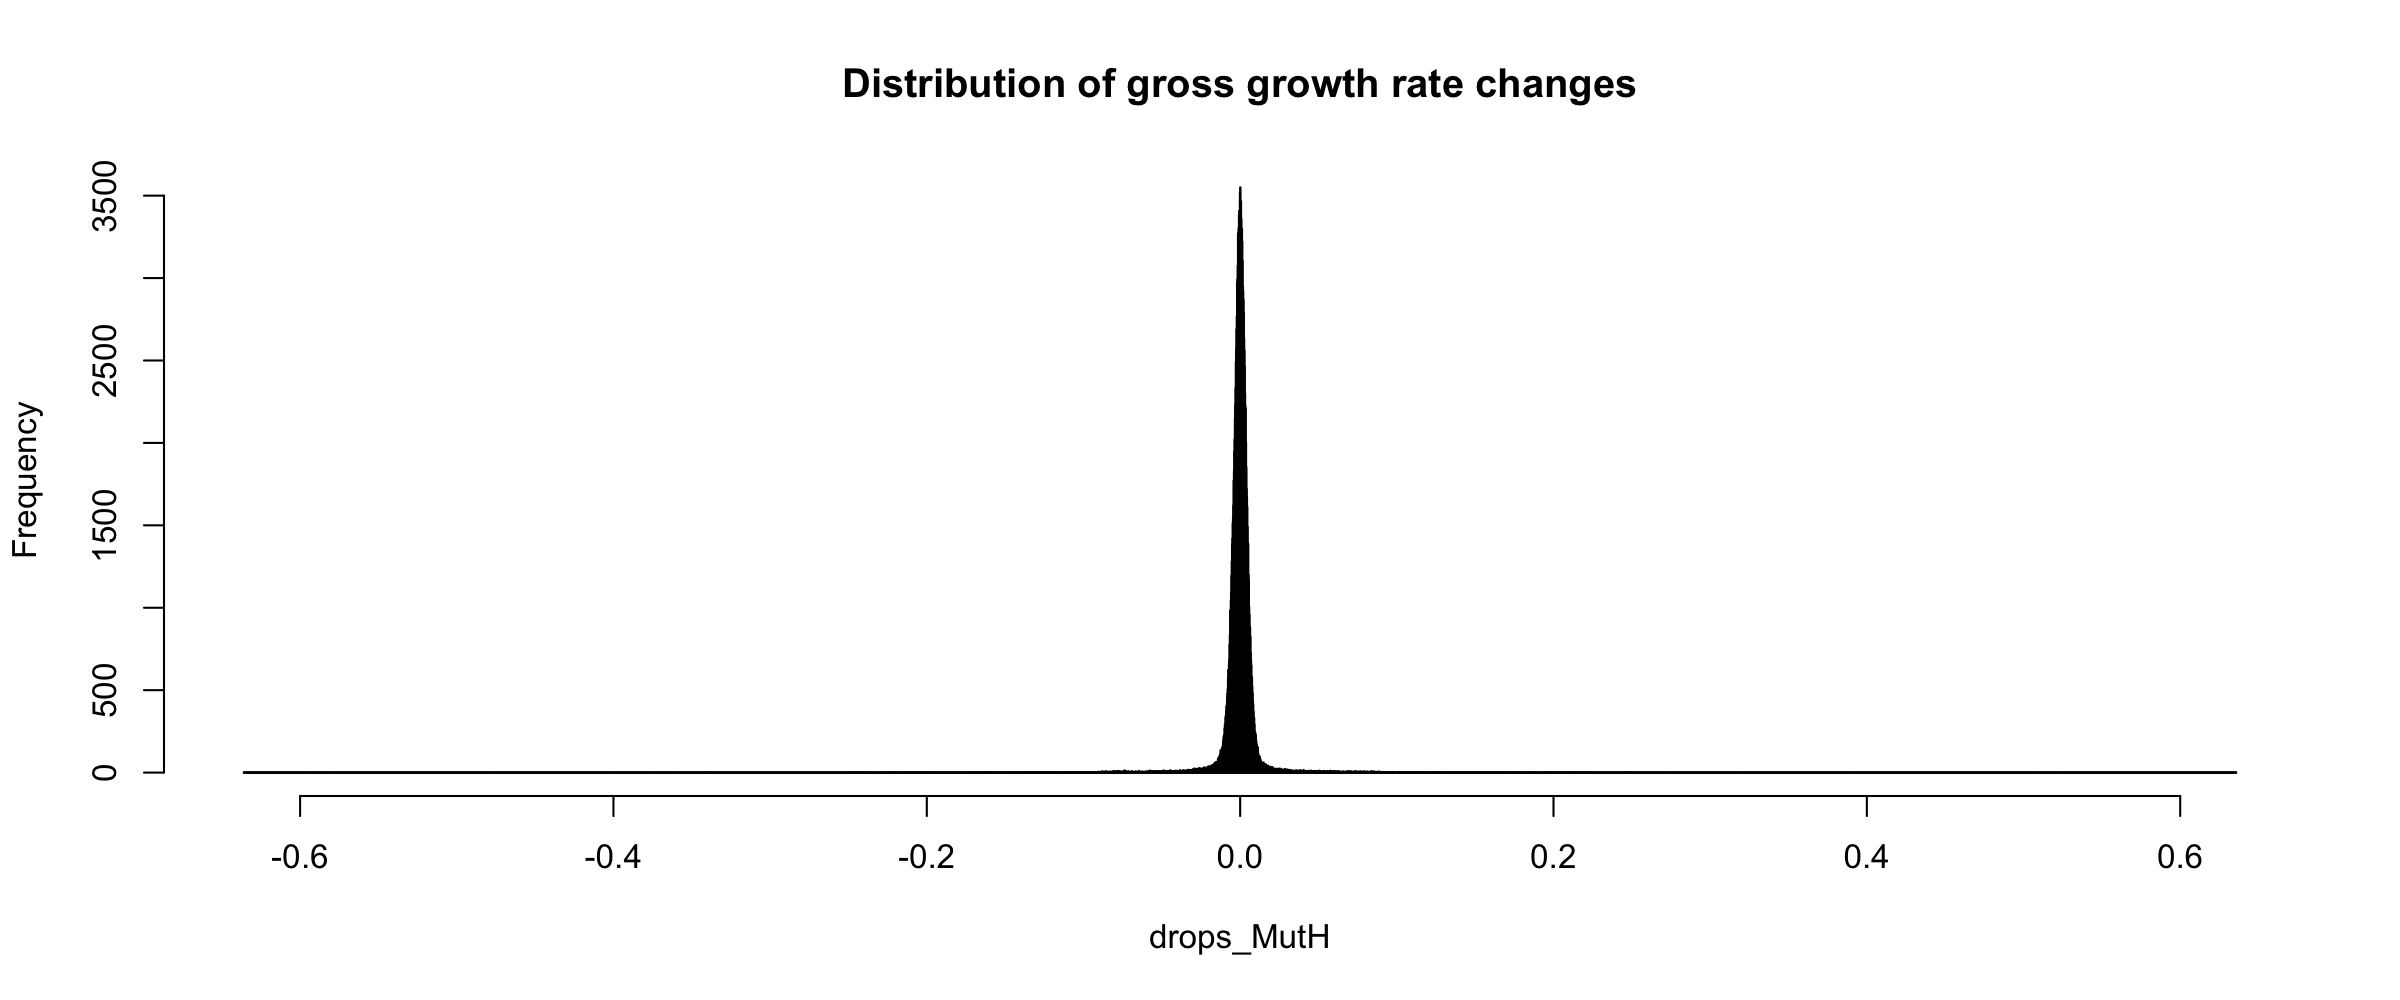

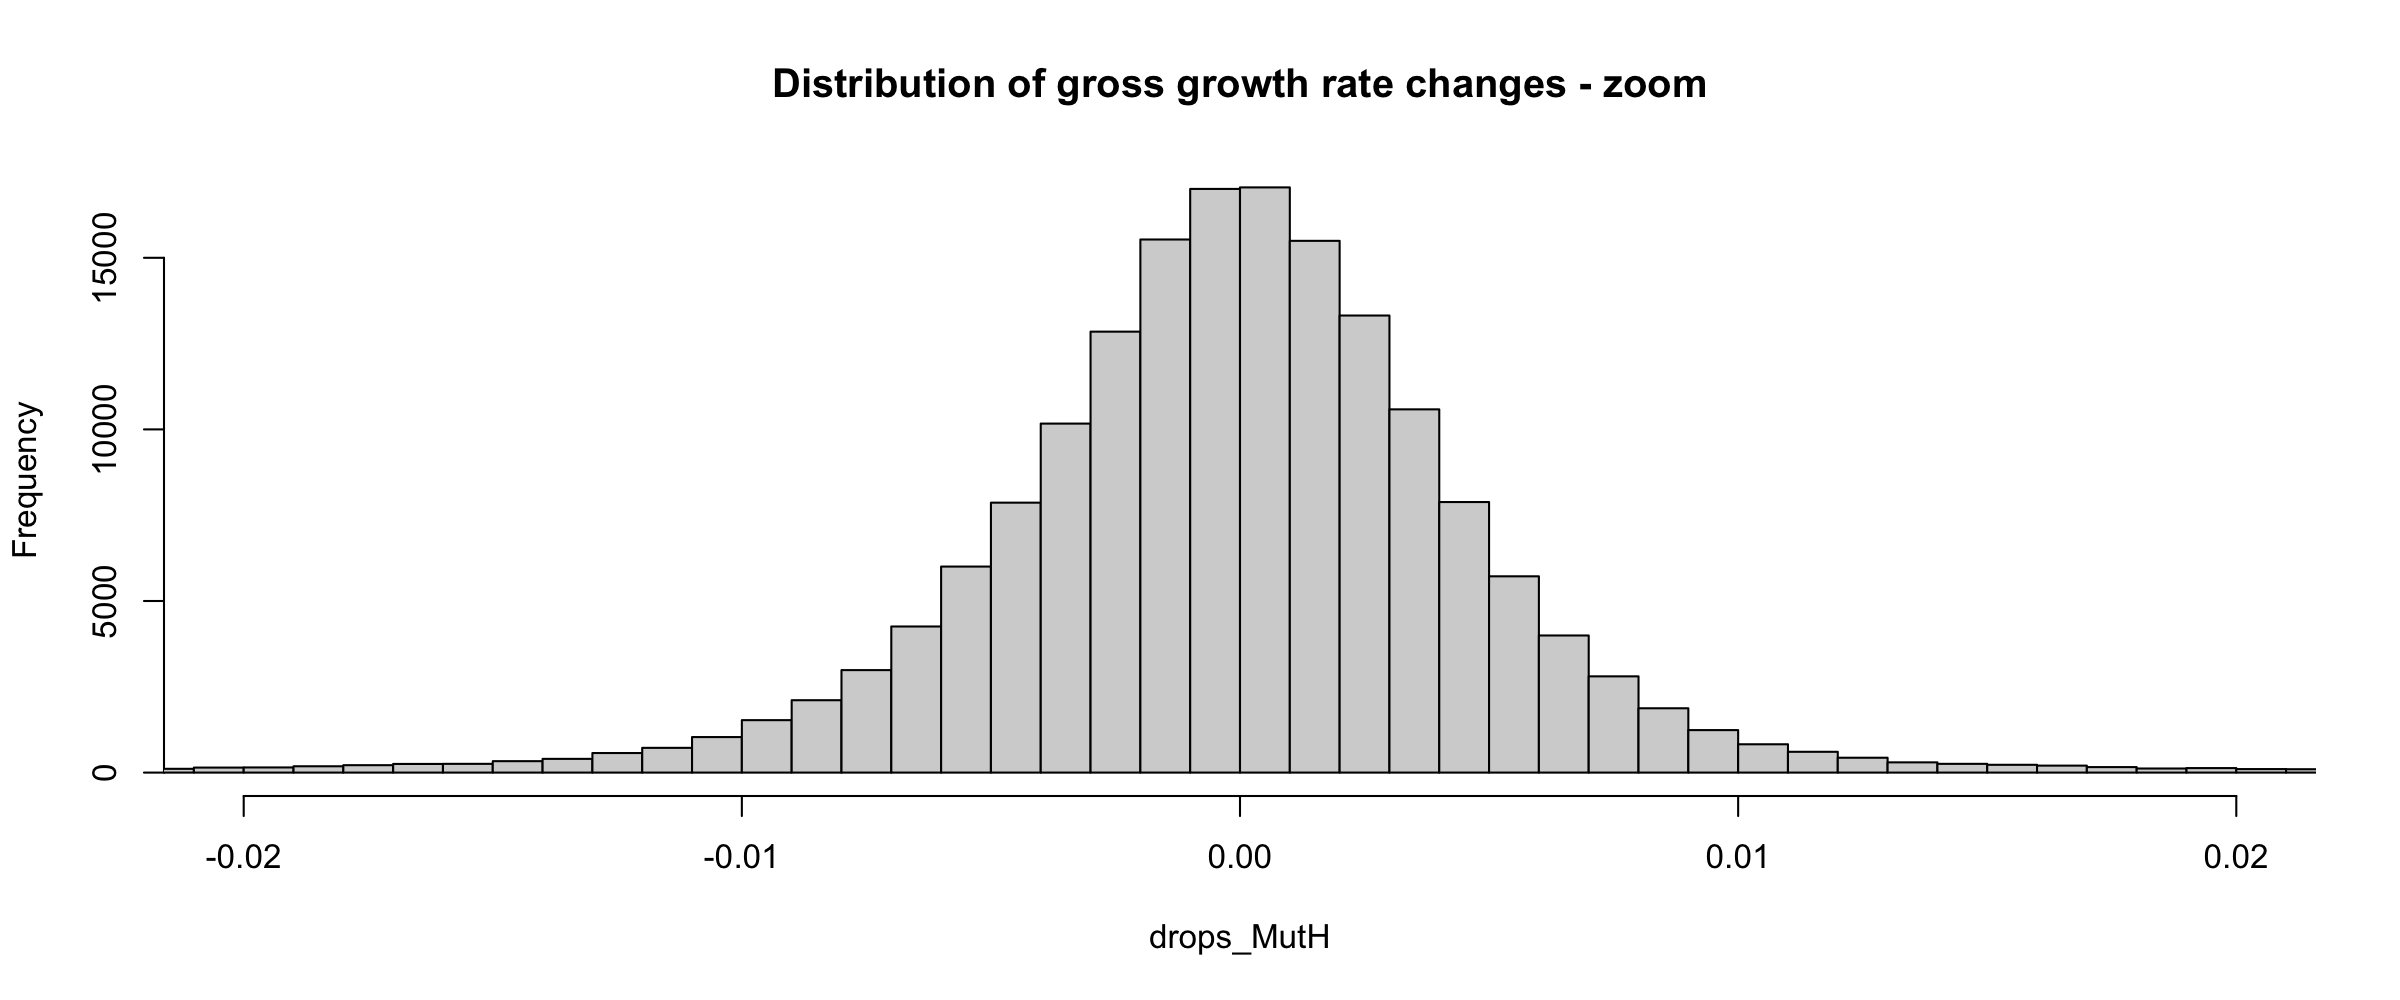

In [133]:
get_drops_col <- function(k, dataset){
    cur_col <- dataset[,k]
    n <- length(cur_col)
    ### tu pourras m'expliquer comment ça marche sapply ? 
    #res <- sapply(1:n-1,
    #              function(i) cur_col[i+1]-cur_col[i])
    res<-cur_col
    for(i in 1:n-1){
        res[i]<-cur_col[i+1]-cur_col[i]
    }
    return (res[res!=0])
}

get_drops <- function(dataset){
    ncol <- dim(dataset)[2]
    res=get_drops_col(1,dataset) ### ugly : can't do better?
    for(k in 2:ncol){
        nouv=get_drops_col(k,dataset)
        res=c(res,nouv)
    }
    return (res)
}
drops_MutH <- get_drops(microMA_MutH_growthRates)

length(drops_MutH)
summary(drops_MutH)
hist(drops_MutH,breaks=5000,
    main="Distribution of gross growth rate changes")
hist(drops_MutH,breaks=1000,
     xlim=c(-0.02,0.02),
    main="Distribution of gross growth rate changes - zoom")


	Shapiro-Wilk normality test

data:  drops_MutH_norm[1:5000]
W = 0.53723, p-value < 2.2e-16


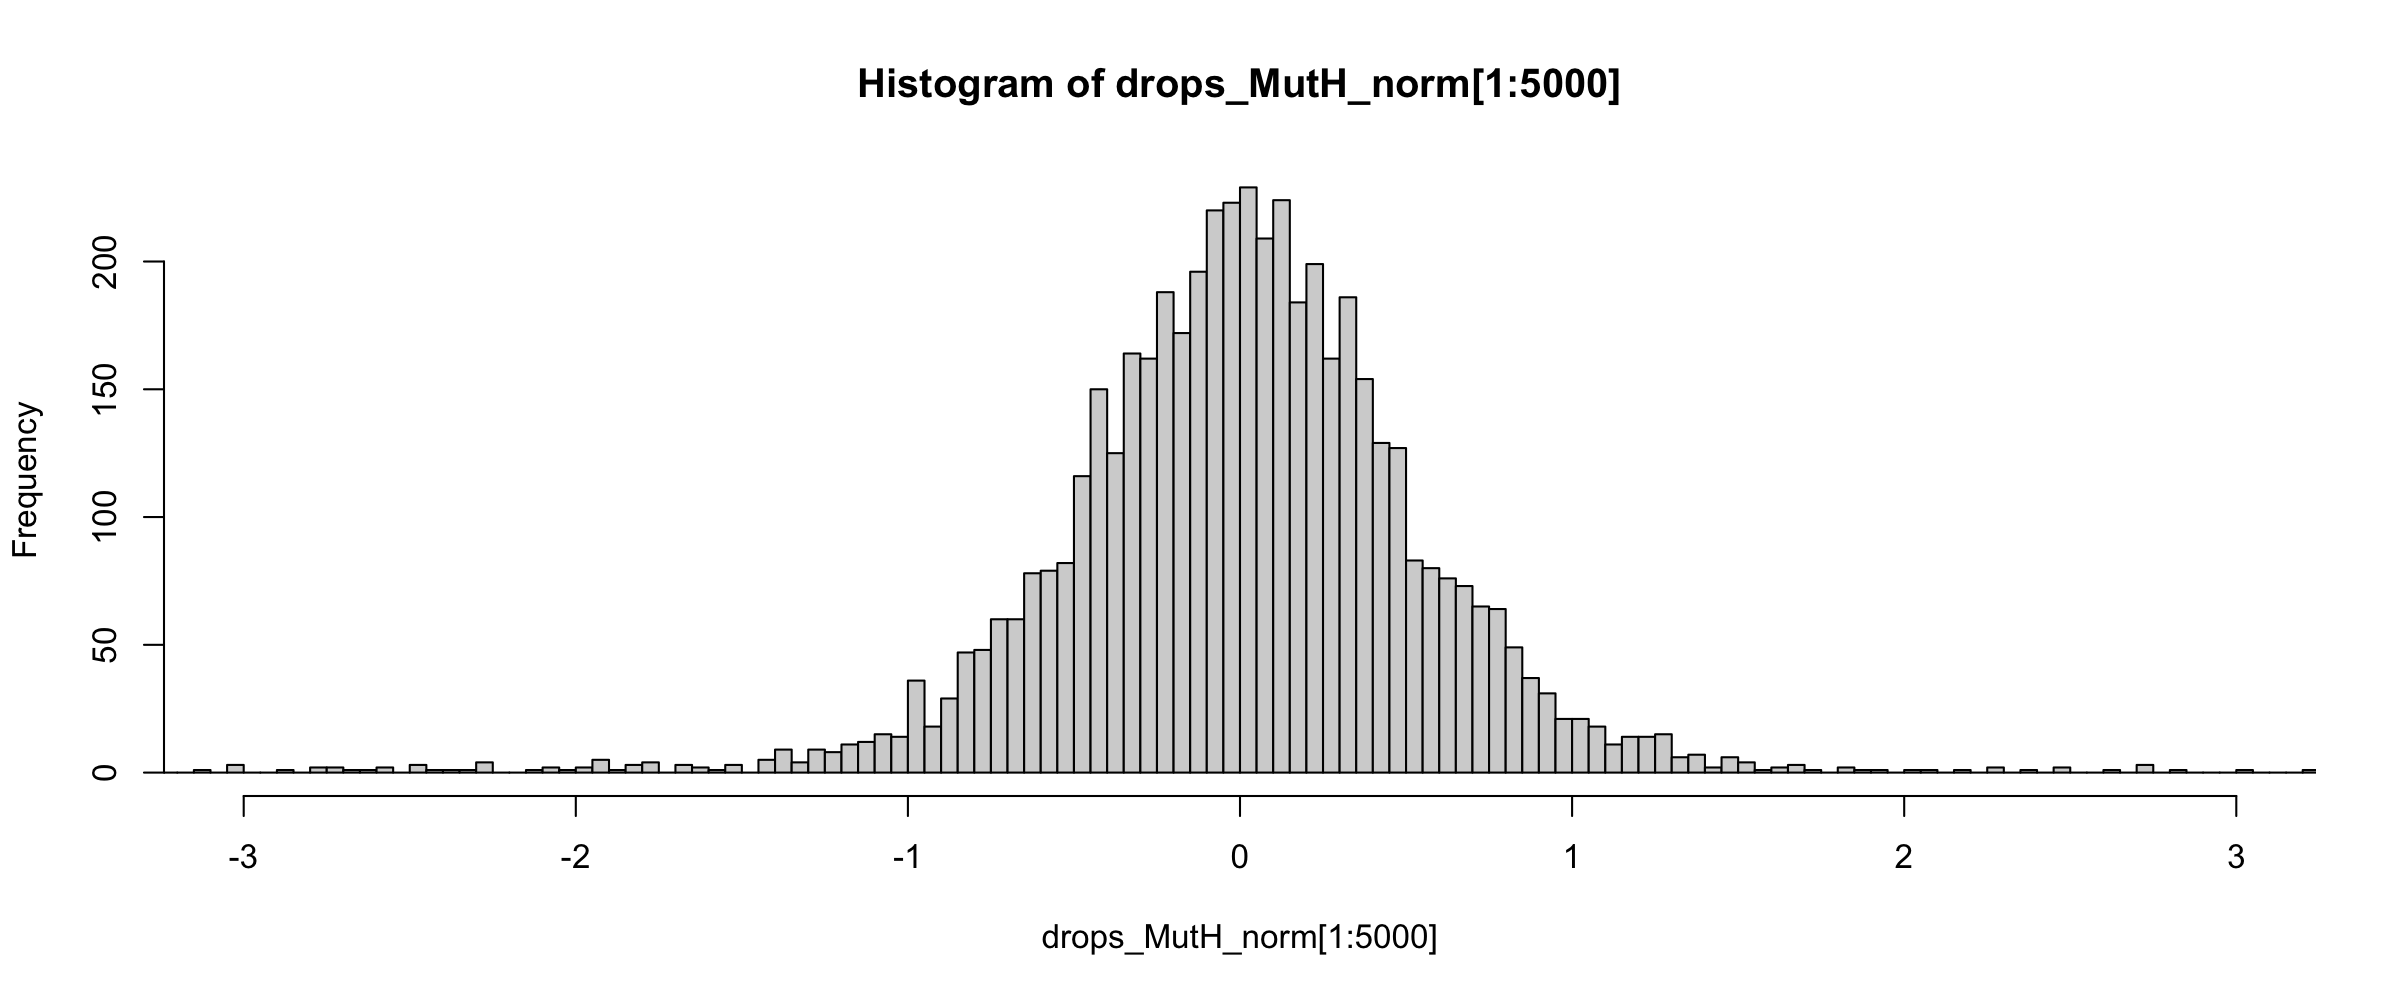

In [134]:
# test de gaussianité :
drops_MutH_sd=sd(drops_MutH[1:5000],na.rm=TRUE)
drops_MutH_mean=mean(drops_MutH[1:5000],na.rm=TRUE)
drops_MutH_norm=(drops_MutH-drops_MutH_mean)/drops_MutH_sd
hist(drops_MutH_norm[1:5000],xlim=c(-3,3),breaks=1000)
shapiro.test(drops_MutH_norm[1:5000])
# pas du tout, pourtant on dirait beaucoup ! (me serais-je trompé ?)

### Relative drops : s=(W'-W)/W

[1] 40301

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-3.33723 -0.08240 -0.00160  0.00474  0.08275 24.95528      276 

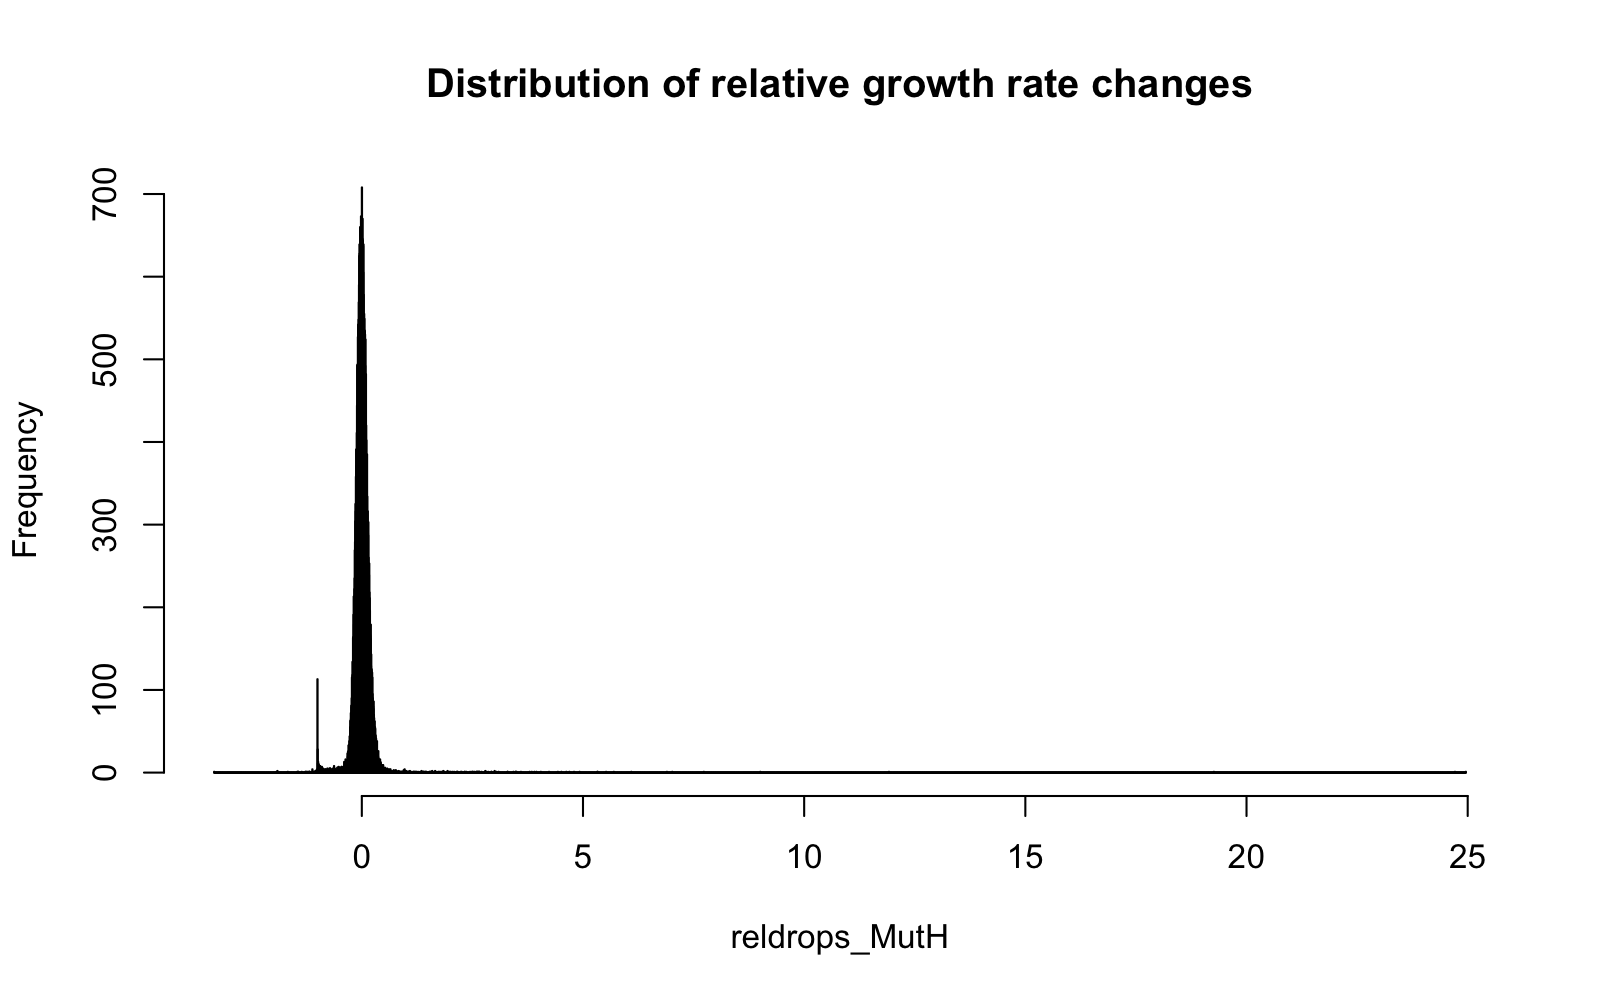

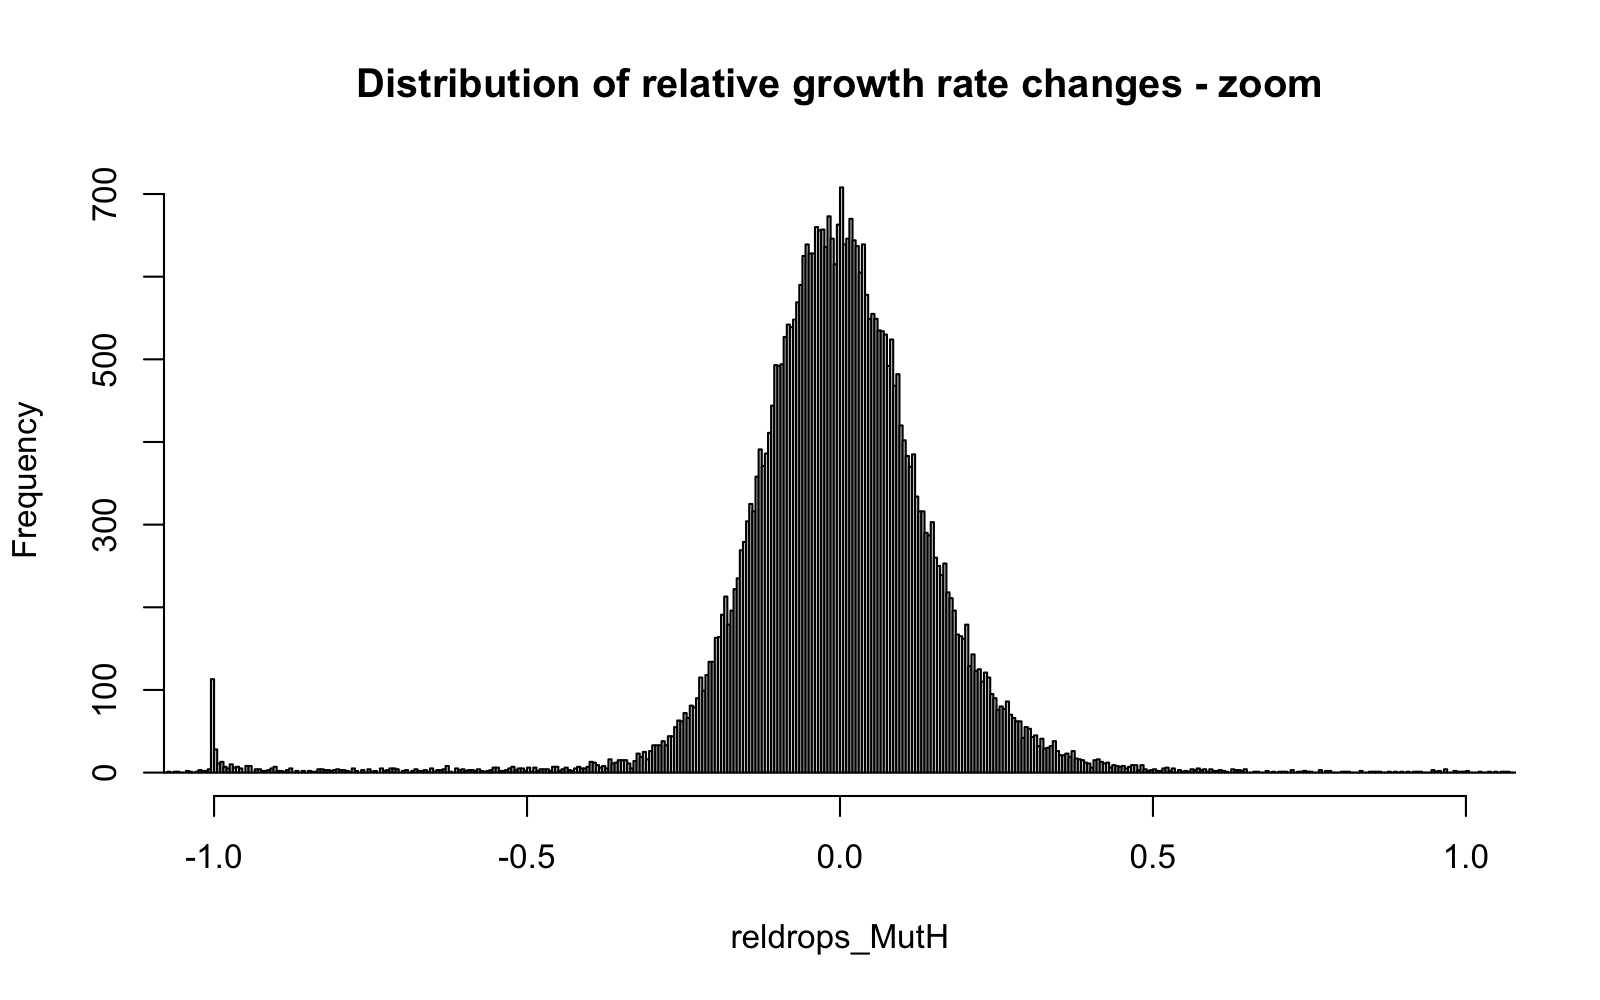

In [34]:
get_reldrops_col <- function(k, dataset){
    cur_col <- dataset[,k]
    n <- length(cur_col)
    ### tu pourras m'expliquer comment ça marche sapply ? 
    #res <- sapply(1:n-1,
    #              function(i) cur_col[i+1]-cur_col[i])
    res<-cur_col
    for(i in 1:n-1){
        ifelse(cur_col[i]>5e-3,
               res[i]<-(cur_col[i+1]-cur_col[i])/cur_col[i],
               res[i]<-0
            )  
    }
    return (res[res!=0])
}

get_reldrops <- function(dataset){
    ncol <- dim(dataset)[2]
    res=get_reldrops_col(1,dataset) ### ugly : can't do better?
    for(k in 2:ncol){
        nouv=get_reldrops_col(k,dataset)
        res=c(res,nouv)
    }
    return (res)
}
reldrops_MutH <- get_reldrops(microMA_MutH_growthRates)

length(reldrops_MutH)
summary(reldrops_MutH)
hist(reldrops_MutH,breaks=5000,
    main="Distribution of relative growth rate changes")
hist(reldrops_MutH,breaks=5000,
     xlim=c(-1,1),
    main="Distribution of relative growth rate changes - zoom")

$\to$ This shape is quite surprising, as it does not correspond to what was expected...

# TO-DO list

  - Voir expériences représentatives : *J1*
  - Identifier et effectuer les mêmes corrections sur les taux de croissance : *J2*
  - Estimer les erreurs sur les moments, mieux borner $\alpha_3$ : maths ou régression (*J4*)
  - Améliorer bornes, en particulier en fonction de $x$ : *N4*
  - Peaufiner méhode dérivée : *N3*
  - Mettre en forme résumé article (*J0-N0*)
  - Ajouter Notebook à l'article
  - Voir $W_t$ comme une chaîne de Markov (tant que les cellules ne meurent pas et ne vieillissent pas), processus de saut dont les incréments suivent la loi de s, mais dans espace non dénombrable, et pas forcément utile
  - Regarder les chutes de taux de croissance : *N1*
  - Simuler avec des distributions de s données (*N2*)
  // Inférence : Approximate *Bayesian* Computation ? Machine Learning ???????